## Exploratory Data Analysis

### Author: Rajiv Swamy
### Course: SML 312

## AirBnB Data Analysis: Austin, TX

In [18]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## New Modeling

In [19]:
# General imports for pre-processing data and modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.feature_selection import RFE, RFECV

# Model selection
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split, cross_val_score 

# Model evaluation
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate


# Ensemble methods
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance

In [20]:
df = pd.read_csv('./airbnb_data/austin/03-2022/listings_cleaned_v3.csv')

In [21]:
df.shape

(11244, 62)

In [22]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'has_availability', 'availability_30', 'availability_90',
       'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings

In [23]:
df.drop(['id','host_id','host_since','host_response_rate','host_acceptance_rate','first_review','last_review','amenities','property_type','calendar_last_scraped'], axis = 1, inplace=True)

df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype(str)

# Limit prices above $1k to $1k, mostly due to sparseness of price distribution above this value, tie in EDA here
df.loc[df['price'] > 1000, 'price'] = 1000


In [24]:
df.shape

(11244, 52)

In [25]:
for col in df.columns.values.tolist():
    print(col)

host_response_time
host_is_superhost
host_total_listings_count
host_has_profile_pic
host_identity_verified
neighbourhood_cleansed
latitude
longitude
room_type
accommodates
bathrooms
bedrooms
beds
price
minimum_nights
maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
has_availability
availability_30
availability_90
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
description_sentiment
host_days_active
host_response_rate_bins
host_acceptance_rate_bins
property_type_clean
amenities_TV
amenities_cooking
amenities_bathtub
amenities_security_cameras
amenities_laundry
amenities_parking
amenities_bbq
amenities_luggage_dropoff
ameni

In [26]:
transformed_df = pd.get_dummies(df, drop_first=True)

In [27]:
transformed_df.shape

(11244, 129)

In [28]:
transformed_df.columns.values.tolist()

['host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_90',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'description_sentiment',
 'host_days_active',
 'amenities_TV',
 'amenities_cooking',
 'amenities_bathtub',
 'amenities_security_cameras',
 'amenities_laundry',
 'amenities_parking',
 'amenities_bbq',
 'amenities_luggage_dropoff',
 'amenities_pool_hot_tub',
 'host_response_time_unknown',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_res

In [29]:
numerical_columns = ['latitude','longitude','accommodates','bathrooms',
                    'bedrooms','beds','price','minimum_nights','maximum_nights','host_total_listings_count',
                    'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                    'availability_30','availability_90','number_of_reviews',
                    'number_of_reviews_ltm','number_of_reviews_l30d',
                    'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                    'host_days_active', 'description_sentiment']


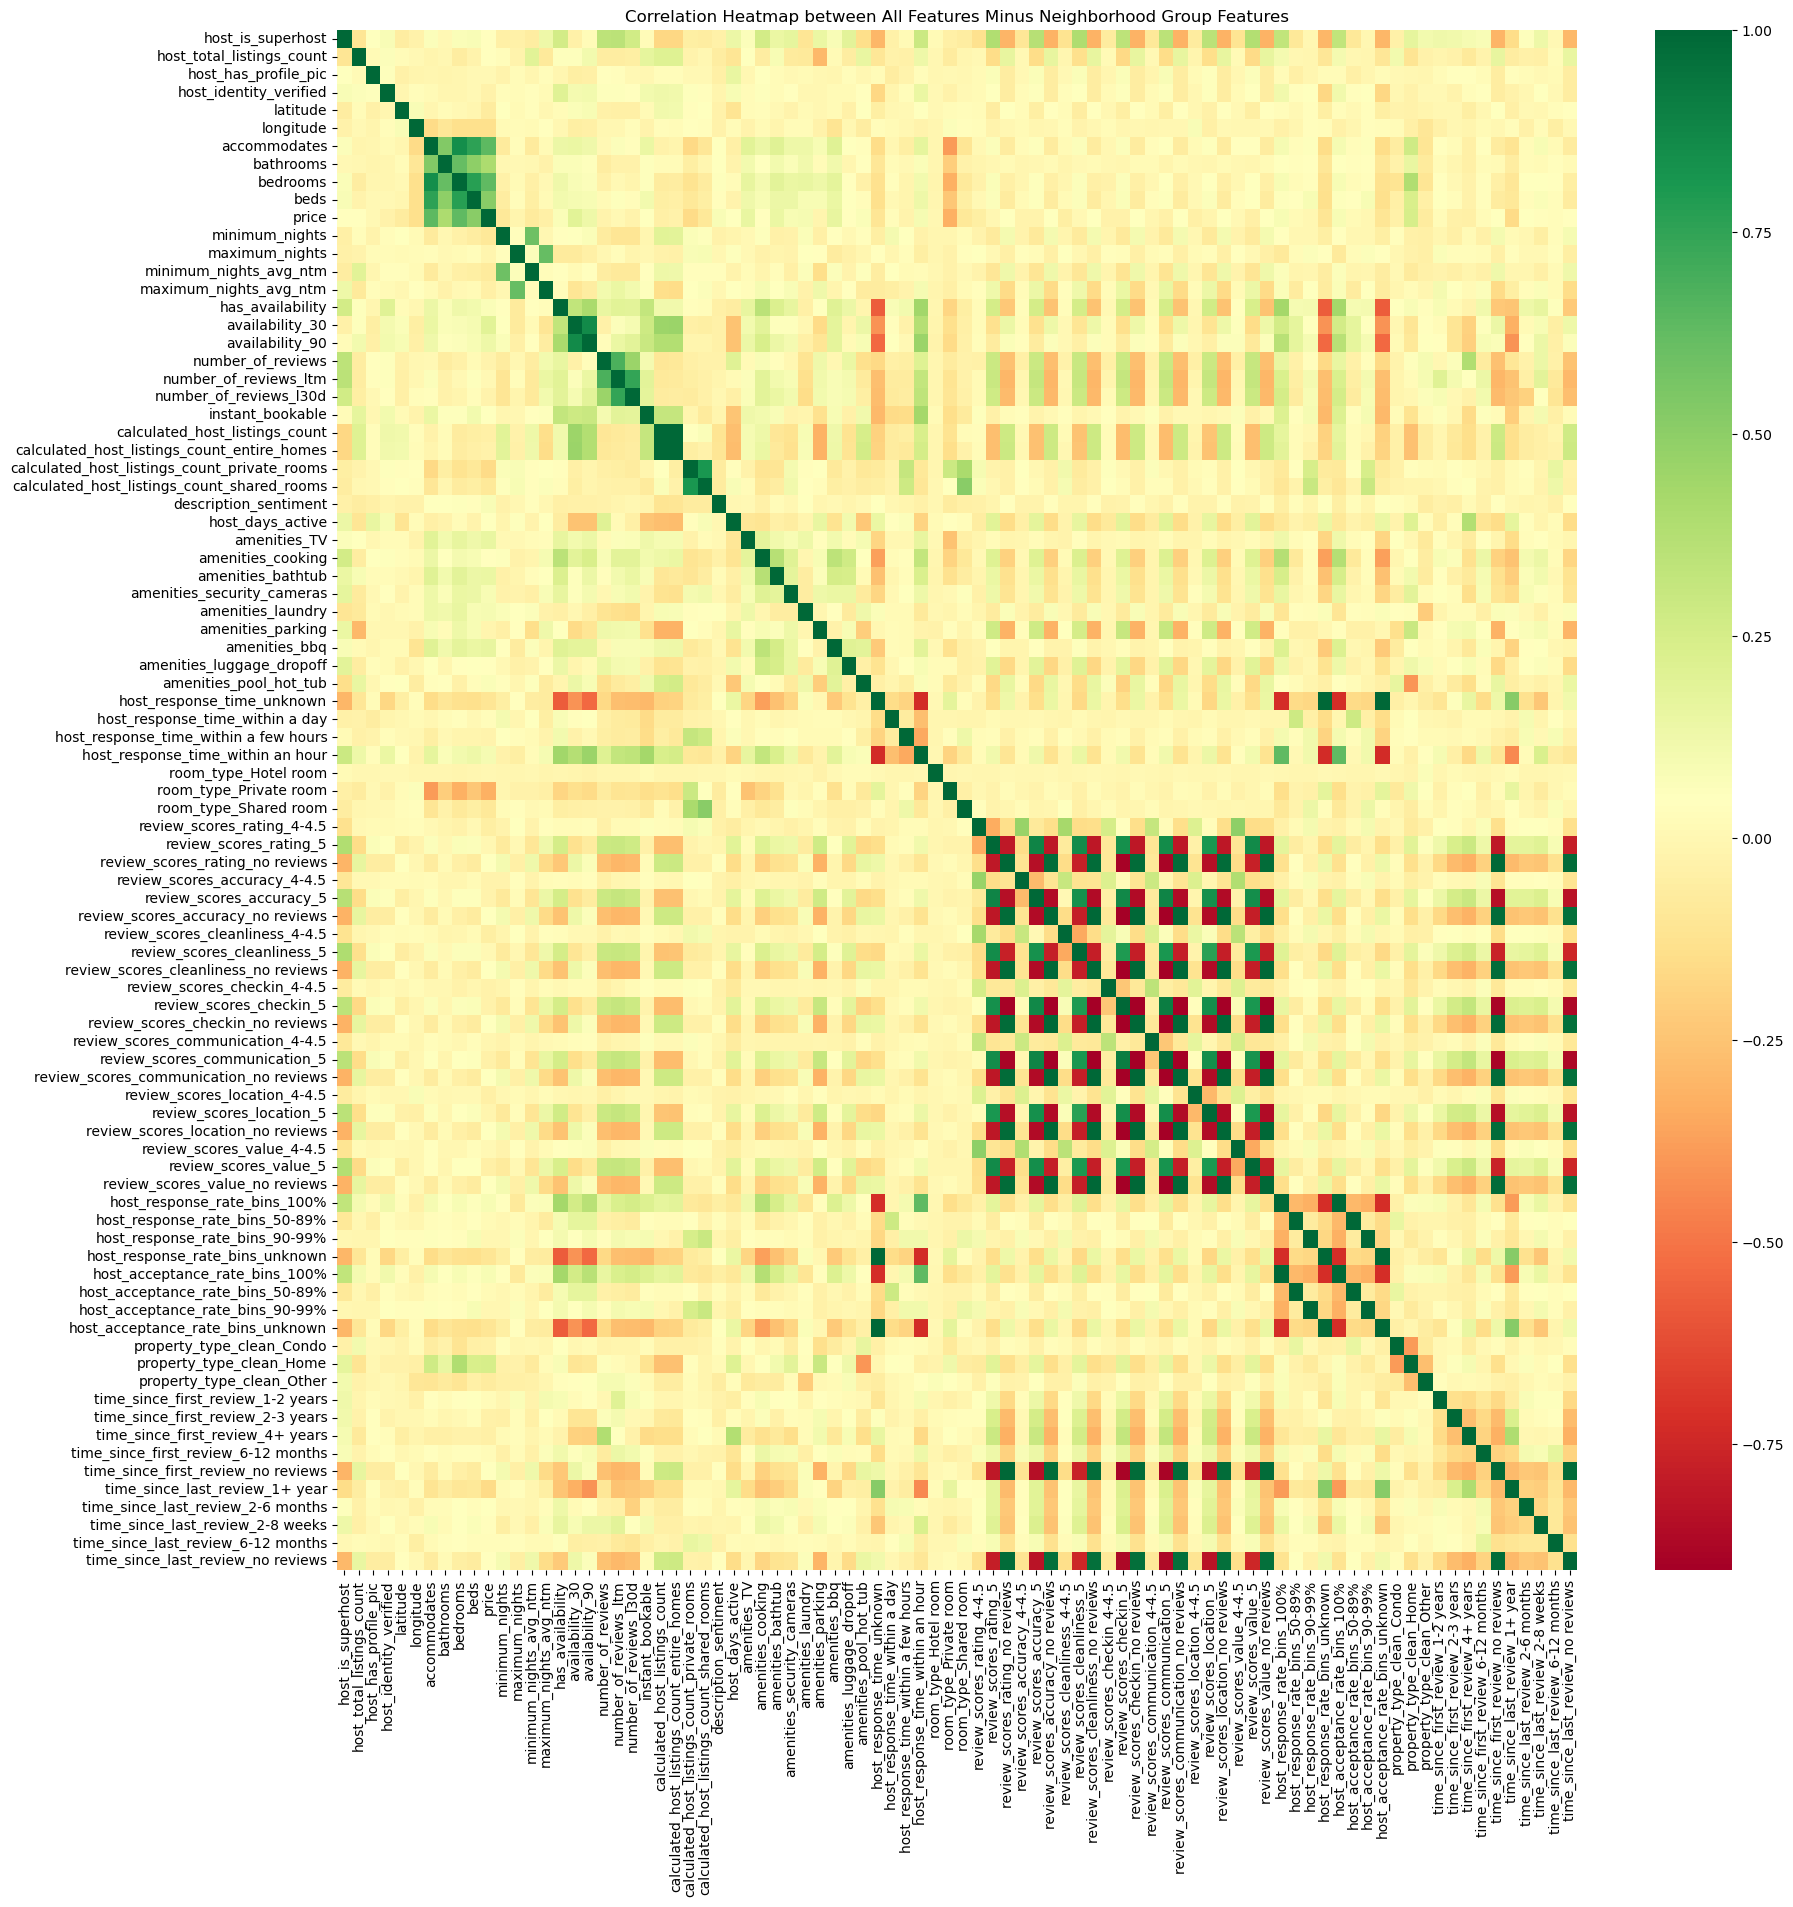

In [30]:
cols_neigh = list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood_cleansed')])

correlation = transformed_df.drop(cols_neigh, axis=1).corr()
plt.subplots(figsize=(20,20))
sns.heatmap(correlation,cmap= 'RdYlGn')
plt.title("Correlation Heatmap between All Features Minus Neighborhood Group Features")
plt.show()

Areas of collinearity (Tightly related columns:

- `beds`, `bedrooms`,`bathrooms` and the number of people that a property `accommodates` are highly correlated. 
- there is perf correlation between `nan` unknown review labels for different review categories
- Same result for `host_response_rate_bins_unknown` and `host_response_time_bins_unknown`. One of these rates will be dropped.


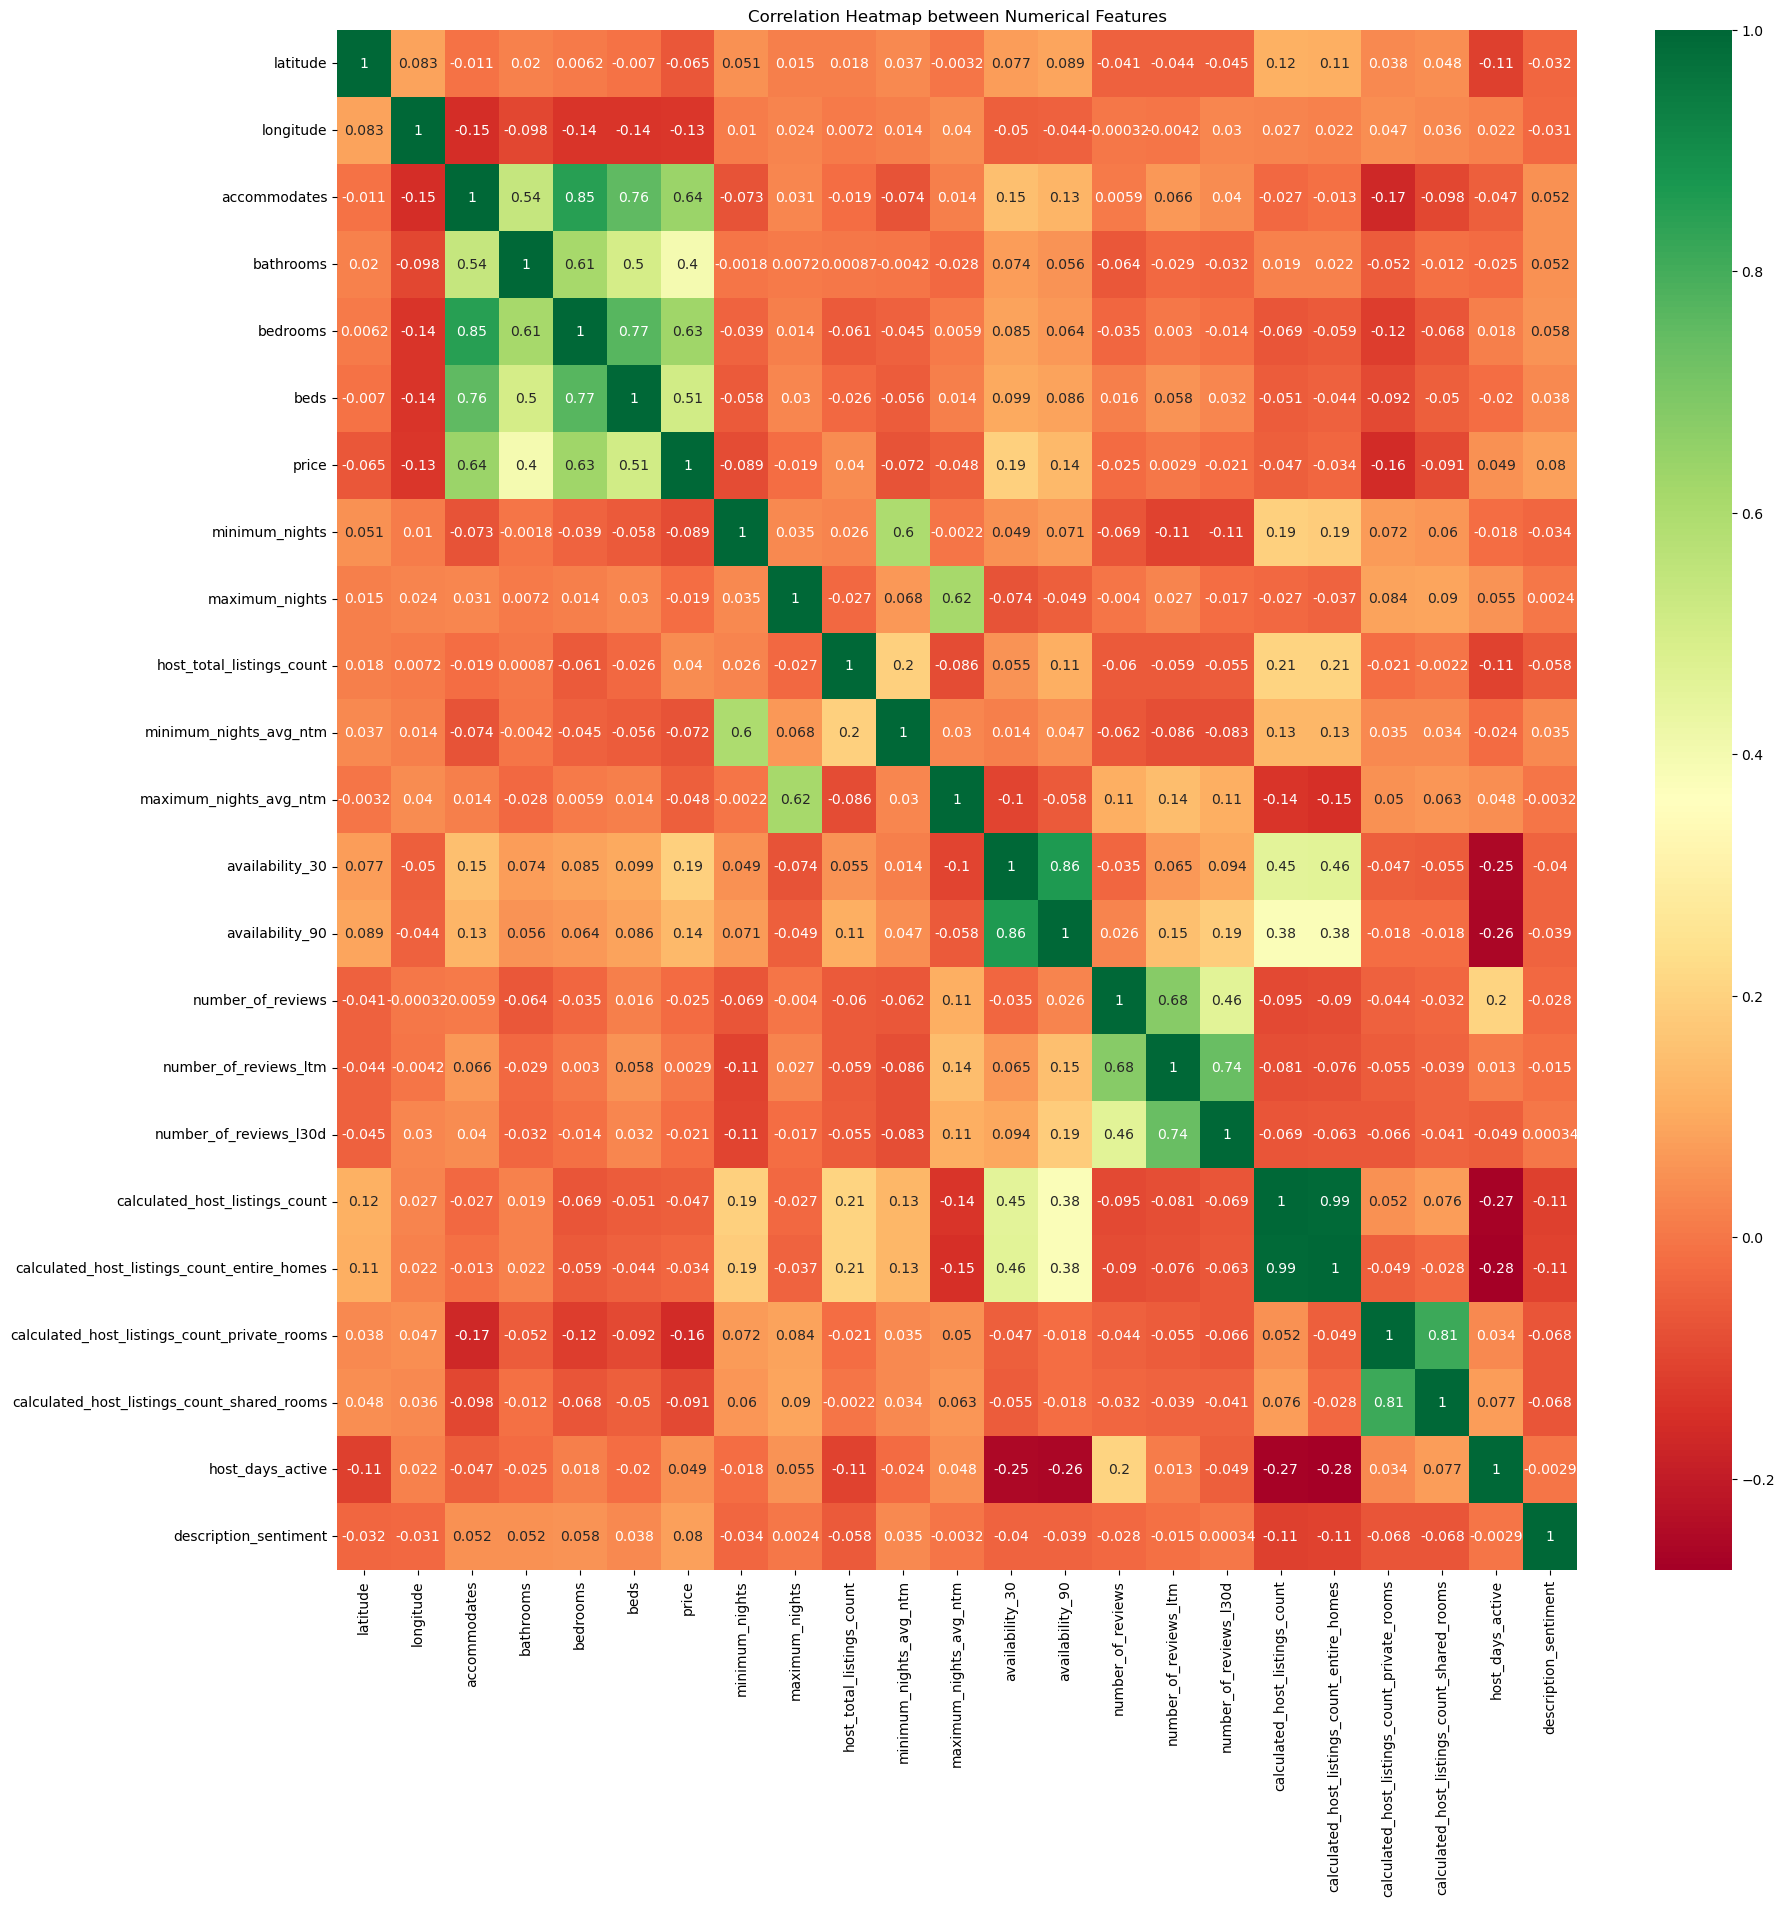

In [31]:
# Numerical only heatmap
# Correlation heatmap, with annotations
correlation = transformed_df[numerical_columns].corr()
plt.subplots(figsize=(20,20))
sns.heatmap(correlation,cmap= 'RdYlGn',annot=True)
plt.title("Correlation Heatmap between Numerical Features")
plt.show()

In [32]:
to_drop = ['beds',
           'bedrooms',
           'calculated_host_listings_count',
           'host_response_rate_bins_unknown',
           'host_response_time_unknown',
           'review_scores_accuracy_no reviews',
           'review_scores_cleanliness_no reviews',
           'review_scores_communication_no reviews',
           'review_scores_location_no reviews',
           'review_scores_value_no reviews']

transformed_df.drop(to_drop, axis=1, inplace=True)

### Standardize and Normalize

array([[<AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'accommodates'}>,
        <AxesSubplot: title={'center': 'bathrooms'}>],
       [<AxesSubplot: title={'center': 'host_total_listings_count'}>,
        <AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'minimum_nights'}>,
        <AxesSubplot: title={'center': 'maximum_nights'}>],
       [<AxesSubplot: title={'center': 'minimum_nights_avg_ntm'}>,
        <AxesSubplot: title={'center': 'maximum_nights_avg_ntm'}>,
        <AxesSubplot: title={'center': 'availability_30'}>,
        <AxesSubplot: title={'center': 'availability_90'}>],
       [<AxesSubplot: title={'center': 'number_of_reviews'}>,
        <AxesSubplot: title={'center': 'number_of_reviews_ltm'}>,
        <AxesSubplot: title={'center': 'number_of_reviews_l30d'}>,
        <AxesSubplot: title={'center': 'calculated_host_listings_count_entire_homes'}>],
   

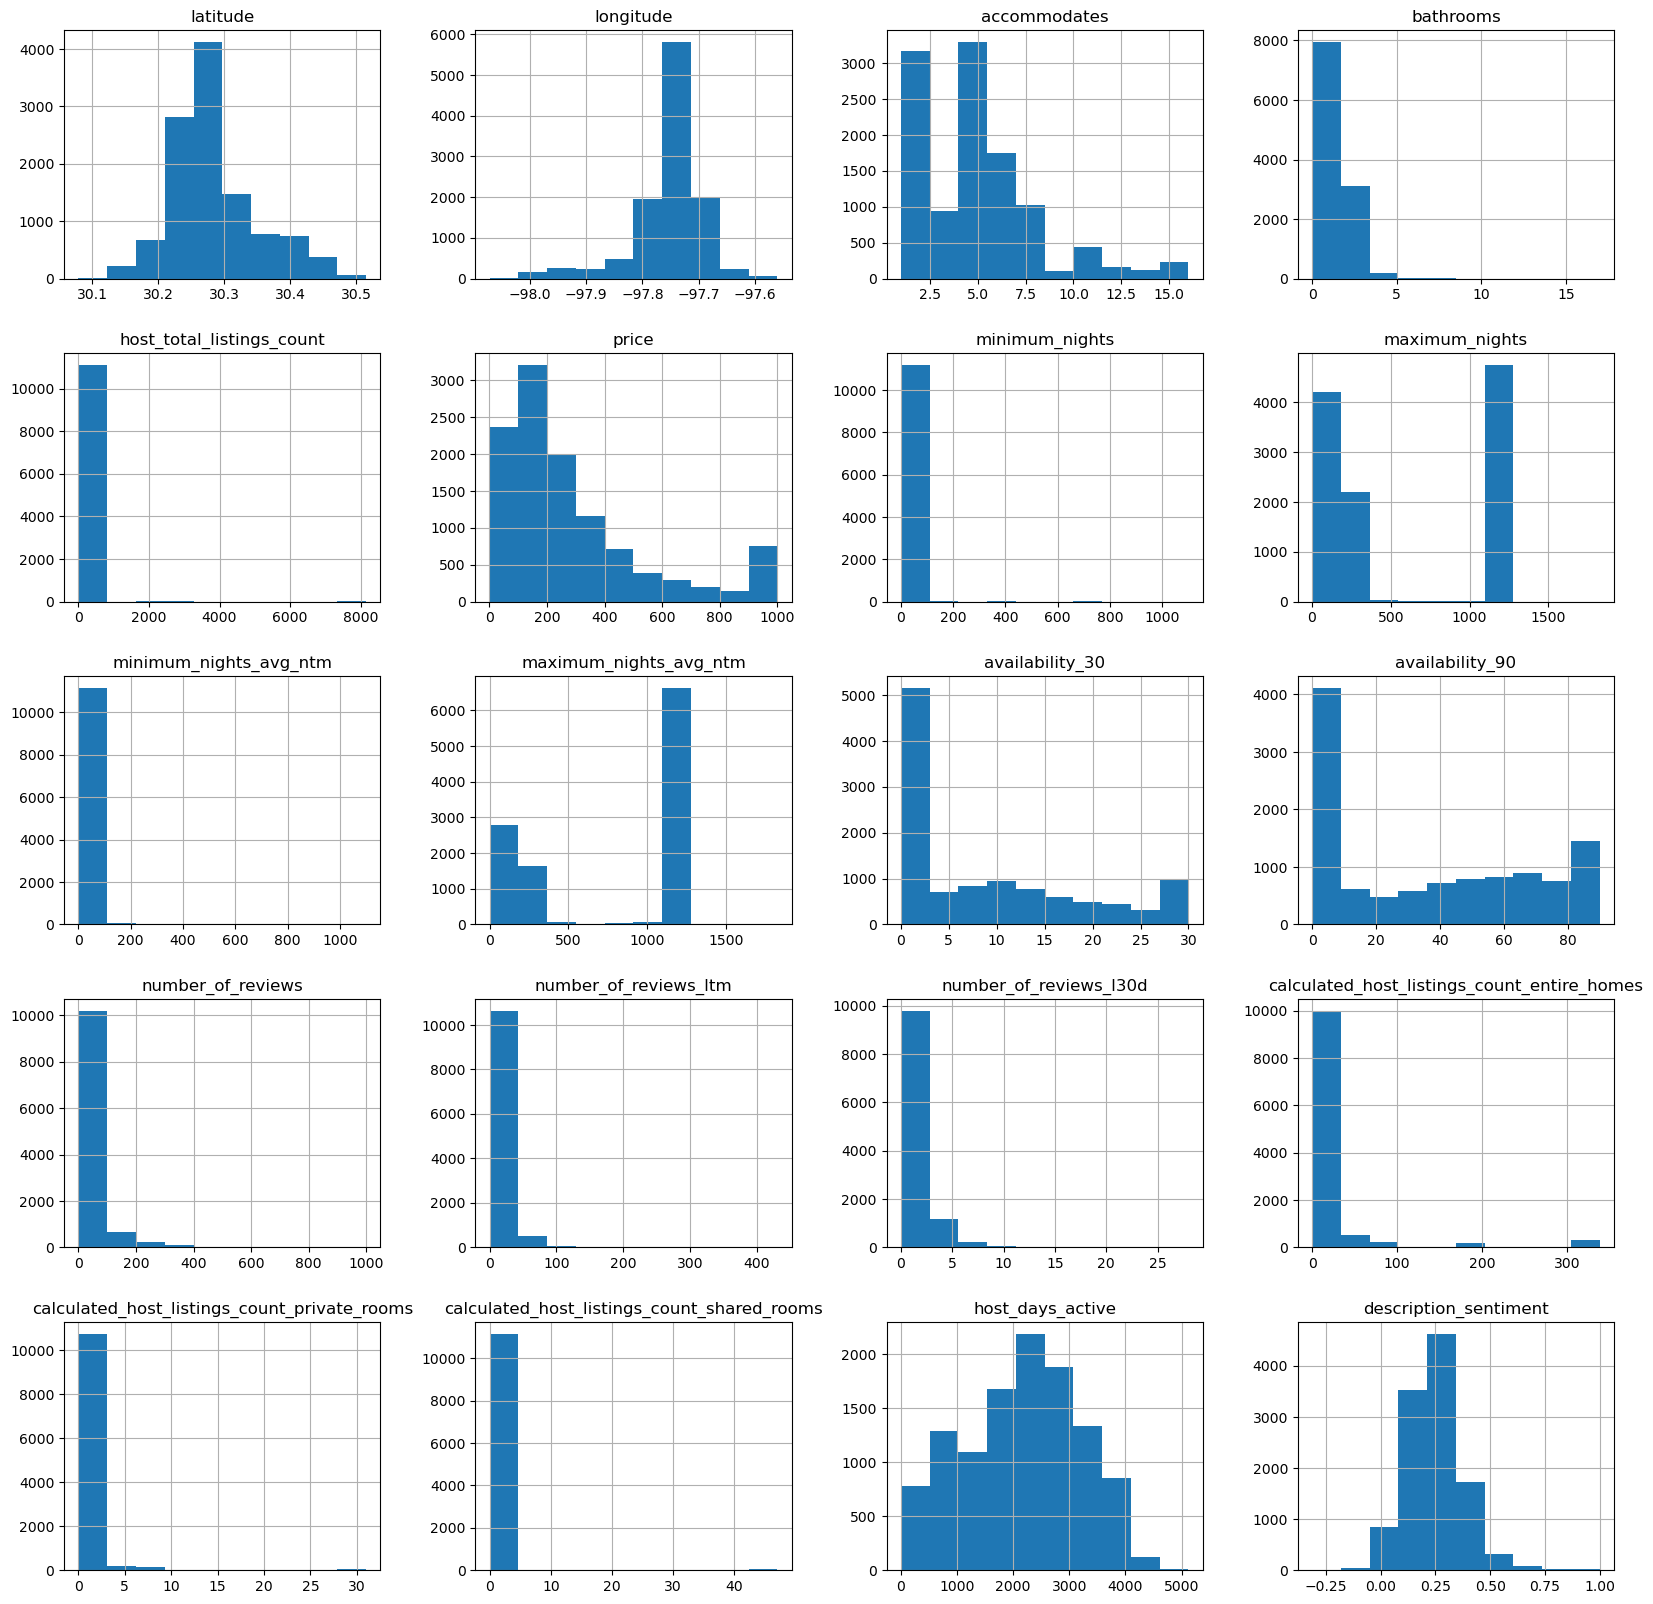

In [33]:
numerical_columns = ['latitude','longitude','accommodates','bathrooms', 'host_total_listings_count',
                    'price','minimum_nights','maximum_nights',
                    'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                    'availability_30','availability_90','number_of_reviews',
                    'number_of_reviews_ltm','number_of_reviews_l30d',
                    'calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                    'host_days_active', 'description_sentiment']

# View numerical columns
transformed_df[numerical_columns].hist(figsize=(20,20))

Other than `availability_30`, `availability_90` and `host_days_active`, latitude/longitude, the remaining numerical features are  postively skewed.

In [34]:
# Log transforming columns
log_numerical_columns = [i for i in numerical_columns 
                     if i not in ['latitude','longitude','availability_30','availability_90', 'host_days_active', 'description_sentiment']] # Removing items not to be transformed

for col in log_numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

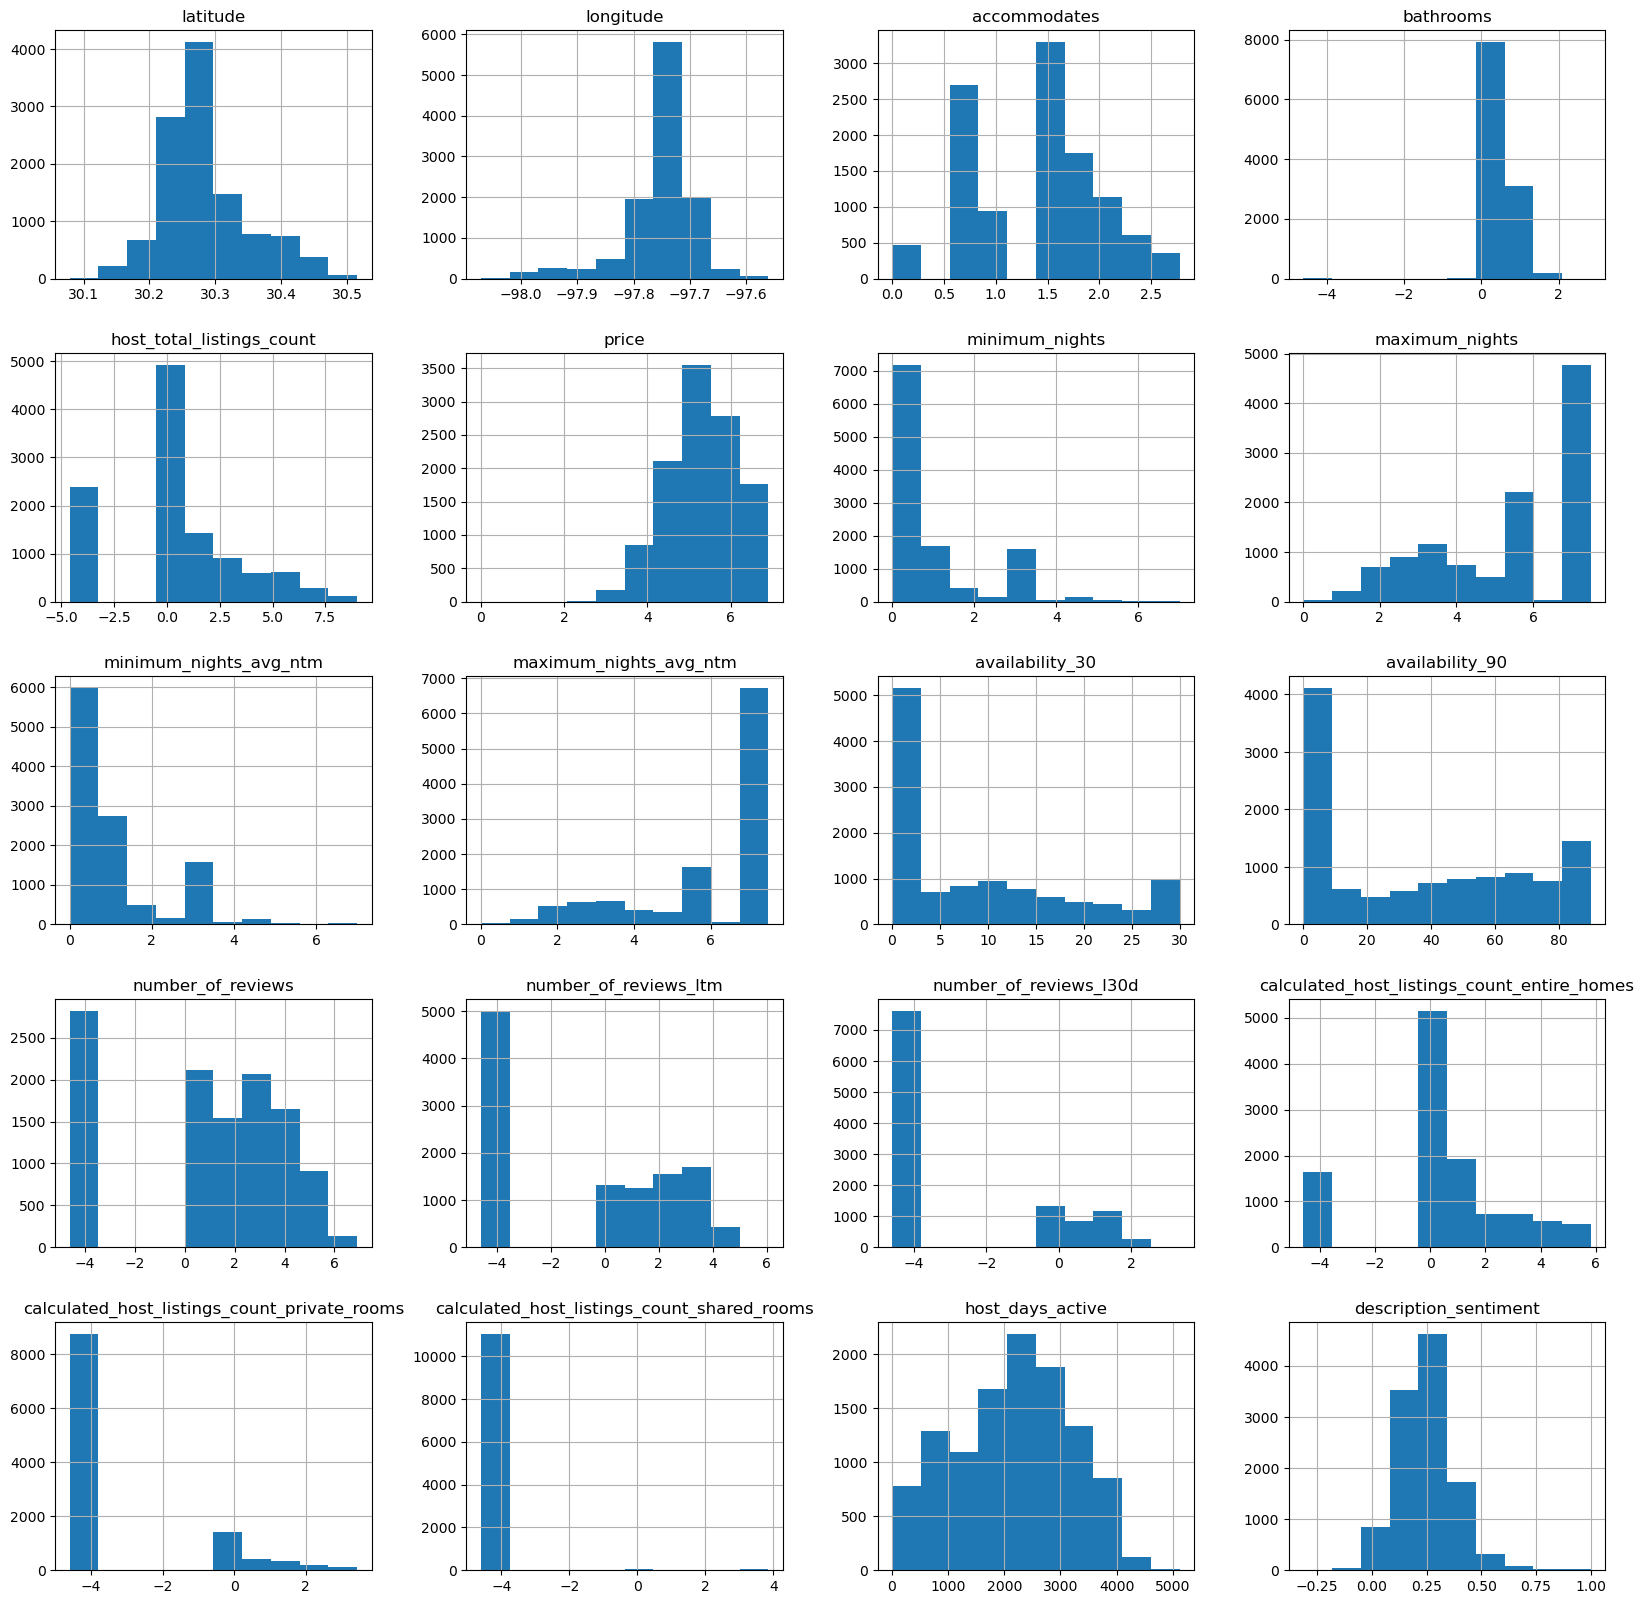

In [35]:
transformed_df[numerical_columns].hist(figsize=(20,20))

### Get X, y data for modeling, scale using standard scaler

In [36]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price
X_unscaled = X.copy()

# Cols of interest
cols = ['latitude','longitude','accommodates','bathrooms', 'host_total_listings_count',
                    'minimum_nights','maximum_nights',
                    'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                    'availability_30','availability_90','number_of_reviews',
                    'number_of_reviews_ltm','number_of_reviews_l30d',
                    'calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                    'host_days_active','description_sentiment']

# Scaling, get zero mean, unit variance for all input features
num_features = X[cols].copy()
scaler = StandardScaler().fit(num_features.values)
num_features = scaler.transform(num_features.values)

X[cols] = num_features


In [37]:
# Splitting into train, validation, and test sets
# Distribution is 80/20, then 80/20 of the 80 percent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=57) 

In [38]:
X_train.shape

(7196, 118)

Print the size of the train, val, and test sets

In [39]:
print(f"Train Set Size; {X_train.shape[0]}")
print(f"Validation Set Size; {X_val.shape[0]}")
print(f"Test Set Size; {X_test.shape[0]}")

Train Set Size; 7196
Validation Set Size; 1799
Test Set Size; 2249


Helper function for executing diff models/algorithms

In [40]:
model_meta_data = []

# Function to execute model and addd metadata
def execute_model(model, model_metadata, X_train, X_test, Y_train, Y_test, id, fit=True):
    if fit:
        model.fit(X_train,Y_train)

    Y_train_pred  = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Acquire train/test MSE scores after inverse transform
    mse_train = mean_squared_error(Y_train,Y_train_pred)
    mse_test = mean_squared_error(Y_test,Y_test_pred)

    # Precision score for train/test data
    rsq_train = r2_score(Y_train,Y_train_pred)
    rsq_test = r2_score(Y_test,Y_test_pred)


    # Acquire train/test MSE scores after inverse transform
    mse_train_inv = mean_squared_error(np.exp(Y_train),np.exp(Y_train_pred))
    mse_test_inv = mean_squared_error(np.exp(Y_test),np.exp(Y_test_pred))

    # Precision score for train/test data
    rsq_train_inv = r2_score(np.exp(Y_train),np.exp(Y_train_pred))
    rsq_test_inv = r2_score(np.exp(Y_test),np.exp(Y_test_pred))

    # Apply 3-fold cross validation to understand model
    scores = cross_validate(model, X_train, Y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)


    print(scores)

    # Store results in model metadata obj
    meta_data = {"model": model, 
                "id": id,
                "r2_train": rsq_train,
                "r2_test": rsq_test,
                "r2_train_inv": rsq_train_inv,
                "r2_test_inv": rsq_test_inv,
                "train_cross_val_r2": scores['train_r2'].mean(),
                "test_cross_val_r2": scores['test_r2'].mean(),
                "mse_train": mse_train,
                "mse_test": mse_test,
                "mse_train_inv": mse_train_inv,
                "mse_test_inv": mse_test_inv,
                "train_cross_val_mse": abs(scores['train_neg_mean_squared_error'].mean()),
                "test_cross_val_mse": abs(scores['test_neg_mean_squared_error'].mean()),
                }
    
    # print values
    for key, val in meta_data.items():
        print(key, val)
    

    model_metadata.append(meta_data)

    return Y_train_pred, Y_test_pred

In [41]:
def plot_pred_actual(actual, pred, model_name):
    fig, ax = plt.subplots(figsize=(5, 4))


    ax.scatter(actual, pred, alpha=.7, color='b') #alpha helps to show overlapping data
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4, label='y=x')

    ax.set_xlabel('Actual Log Price')  
    ax.set_ylabel('Predicted Log Price')
    ax.legend()
    ax.set_title(model_name)  
    plt.show()

def plot_pred_actual_inv(actual, pred, model_name):
    fig, ax = plt.subplots(figsize=(5, 4))


    ax.scatter(np.exp(actual), np.exp(pred), alpha=.7, color='b') #alpha helps to show overlapping data
    ax.plot([np.exp(actual).min(), np.exp(actual).max()], [np.exp(actual).min(), np.exp(actual).max()], 'k--', lw=4, label='y=x')

    ax.set_xlabel('Actual Price')  
    ax.set_ylabel('Predicted Price')
    ax.legend()
    ax.set_title(model_name)  
    plt.show()

def analyze_predictions(y, y_pred, model_name):
    y_inv = np.exp(y)
    y_pred_inv = np.exp(y_pred)
    mae_error = np.abs((y_inv - y_pred_inv))
    mse_error = (y_inv - y_pred_inv)**2

    
    res = pd.DataFrame({'price':np.exp(y),'price_pred':np.exp(y_pred), 'mse_error': mse_error,'mae_error':mae_error})

    res['bins'] = pd.cut(res['price'], bins=[0, 100, 200, 500, res['price'].max()], labels=['$0-$100', '$100-$200', '$200-$500', '$500-max'], include_lowest=True)

    print(res.groupby('bins')['mse_error'].median()**(1/2))
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # sns.violinplot(x='bins',y='mse_error',data=res, cut = 0,ax=ax) 
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4))
    sns.violinplot(x='bins',y='mae_error',data=res, cut = 0, ax=ax1)
    ax1.set_xlabel('Actual Price Bins')  
    ax1.set_ylabel('MAE')
    
    ax1.set_title('Error Across Price Ranges: '+model_name)  

{'fit_time': array([0.05247211, 0.05360365, 0.05476213, 0.05232882, 0.05189919]), 'score_time': array([0.00616717, 0.00434613, 0.00422883, 0.00382113, 0.00405884]), 'test_r2': array([ 6.60486666e-01,  6.30674896e-01,  6.11817269e-01, -1.23151725e+14,
       -2.11867767e+16]), 'train_r2': array([0.64245317, 0.64889287, 0.65396591, 0.64972695, 0.65080797]), 'test_neg_mean_squared_error': array([-2.59544453e-01, -2.56418055e-01, -2.95295786e-01, -9.35993891e+13,
       -1.69480439e+16]), 'train_neg_mean_squared_error': array([-0.26955232, -0.2708683 , -0.26121598, -0.26441254, -0.26017536])}
model LinearRegression()
id lin-reg
r2_train 0.6475222405257568
r2_test 0.6652579751331933
r2_train_inv 0.5622002233770234
r2_test_inv 0.5755871664289919
train_cross_val_r2 0.6491693741165622
test_cross_val_r2 -4261985693783889.5
mse_train 0.2664910265491383
mse_test 0.25180789156752403
mse_train_inv 29266.28838496465
mse_test_inv 26375.659883811644
train_cross_val_mse 0.2652449006276572
test_cross_va

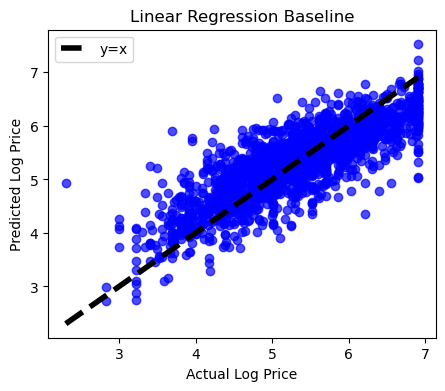

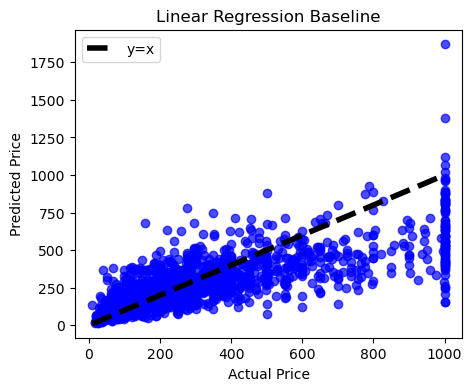

bins
$0-$100       28.120689
$100-$200     45.131242
$200-$500     73.428922
$500-max     266.722953
Name: mse_error, dtype: float64


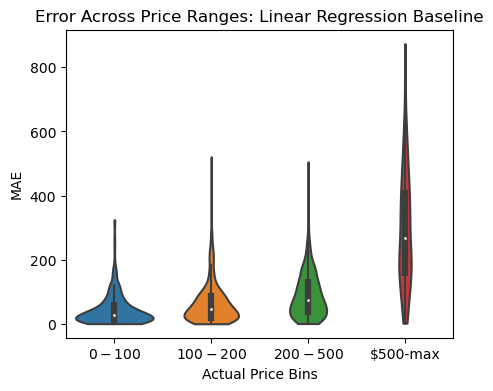

In [42]:
# Fit and analyze linear regression model
lin_reg = LinearRegression()  

# Run model with helper function
y_train_pred, y_val_pred = execute_model(lin_reg, model_meta_data, X_train, X_val, y_train, y_val, 'lin-reg')

plot_pred_actual(y_val, y_val_pred,'Linear Regression Baseline')
plot_pred_actual_inv(y_val, y_val_pred,'Linear Regression Baseline')
analyze_predictions(y_val,y_val_pred, 'Linear Regression Baseline')

Analyze linear regression only using one variable

### Ridge Regressionn
Application of L2 regularizer

{'fit_time': array([0.02060413, 0.01820111, 0.01852083, 0.01860094, 0.0180912 ]), 'score_time': array([0.00416088, 0.00401211, 0.00383735, 0.00444579, 0.00394106]), 'test_r2': array([0.66210309, 0.62968922, 0.61224294, 0.62930968, 0.62485809]), 'train_r2': array([0.64127333, 0.64798748, 0.65288172, 0.64874986, 0.64991295]), 'test_neg_mean_squared_error': array([-0.25830876, -0.2571024 , -0.29497197, -0.28173692, -0.30008914]), 'train_neg_mean_squared_error': array([-0.27044179, -0.27156678, -0.26203442, -0.26515012, -0.26084222])}
model Ridge()
id ridge
r2_train 0.6467793176077925
r2_test 0.6663898613181497
r2_train_inv 0.56067329856194
r2_test_inv 0.577085623387414
train_cross_val_r2 0.648161067919184
test_cross_val_r2 0.6316406031416708
mse_train 0.2670527138775827
mse_test 0.25095643625998776
mse_train_inv 29368.361123158094
mse_test_inv 26282.536424859358
train_cross_val_mse 0.2660070676592739
test_cross_val_mse 0.27844183818864954


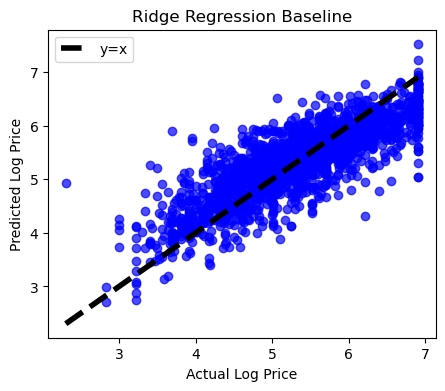

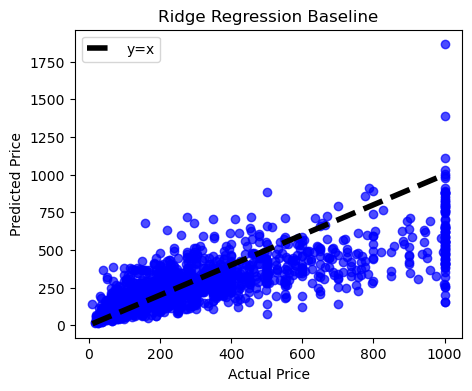

bins
$0-$100       28.156345
$100-$200     45.369204
$200-$500     74.123747
$500-max     263.030824
Name: mse_error, dtype: float64


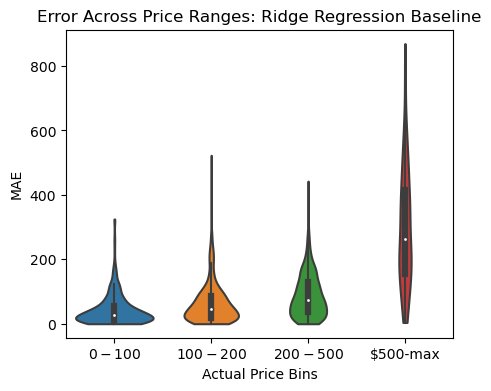

In [43]:
# Fit and analyze linear regression model
lin_reg = linear_model.Ridge()  

# Run model with helper function
y_train_pred, y_val_pred = execute_model(lin_reg, model_meta_data, X_train, X_val, y_train, y_val, 'ridge')

plot_pred_actual(y_val, y_val_pred,'Ridge Regression Baseline')
plot_pred_actual_inv(y_val, y_val_pred,'Ridge Regression Baseline')
analyze_predictions(y_val,y_val_pred, 'Ridge Regression Baseline')

### Lasso Regression

{'fit_time': array([0.07156205, 0.11496425, 0.11115789, 0.07501793, 0.04964113]), 'score_time': array([0.00699377, 0.00551391, 0.01098776, 0.00507689, 0.00427413]), 'test_r2': array([0.6082249 , 0.57328722, 0.55535579, 0.57080125, 0.56742181]), 'train_r2': array([0.57366119, 0.58194237, 0.58606381, 0.58153099, 0.58185799]), 'test_neg_mean_squared_error': array([-0.2994965 , -0.29626164, -0.33824678, -0.32620526, -0.34603443]), 'train_neg_mean_squared_error': array([-0.32141416, -0.32251854, -0.31247427, -0.315892  , -0.31154849])}
model Lasso(alpha=0.01)
id lasso
r2_train 0.5802139135870952
r2_test 0.5848260112588197
r2_train_inv 0.45869386863068184
r2_test_inv 0.43738805358525124
train_cross_val_r2 0.5810112707454415
test_cross_val_r2 0.5750181961993558
mse_train 0.3173795284731857
mse_test 0.313916298478204
mse_train_inv 36185.54003705401
mse_test_inv 38699.4260574177
train_cross_val_mse 0.3167694908845824
test_cross_val_mse 0.321248921019308


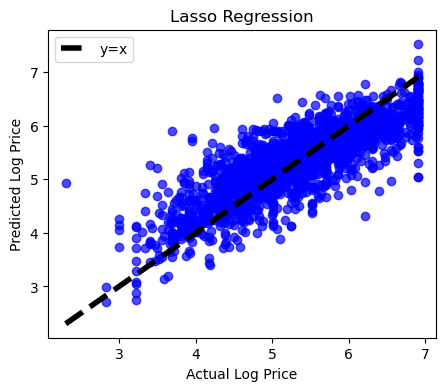

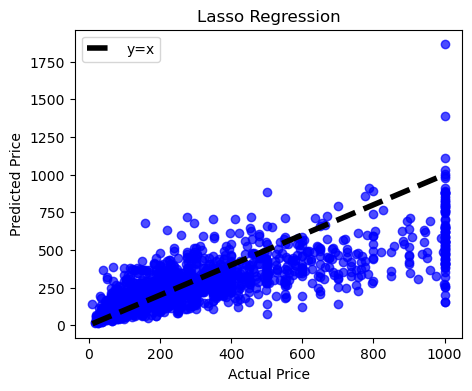

bins
$0-$100       28.156345
$100-$200     45.369204
$200-$500     74.123747
$500-max     263.030824
Name: mse_error, dtype: float64


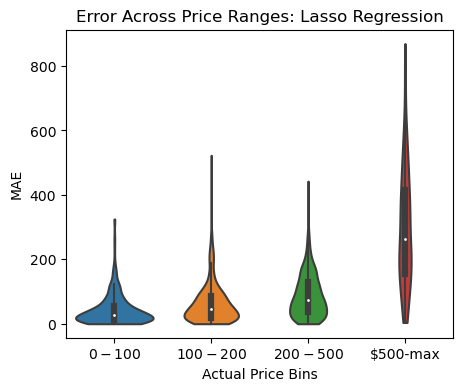

In [44]:
# Fit and analyze linear regression model
lin_reg = linear_model.Lasso(alpha=0.01)  

# Run model with helper function
y_train_pred, y_test_pred = execute_model(lin_reg, model_meta_data, X_train, X_test, y_train, y_test, 'lasso')

plot_pred_actual(y_val, y_val_pred,'Lasso Regression')
plot_pred_actual_inv(y_val, y_val_pred,'Lasso Regression')
analyze_predictions(y_val,y_val_pred, 'Lasso Regression')

### Embedded Feature Selection from Lasso Regression

In [45]:
cols = np.array(X_val.columns)
coeff = lin_reg.coef_
mag = np.abs(coeff)

data = {"feature":cols, "coeff":coeff, "magnitude":mag}

df = pd.DataFrame(data)

df.sort_values('magnitude', ascending=False).head(15)

feature     coeff  magnitude
6                                    accommodates  0.386869   0.386869
36                   neighbourhood_cleansed_78702  0.184332   0.184332
106                      property_type_clean_Home  0.165574   0.165574
38                   neighbourhood_cleansed_78704  0.164441   0.164441
113                time_since_last_review_1+ year -0.121817   0.121817
20   calculated_host_listings_count_private_rooms -0.114107   0.114107
80                         room_type_Private room -0.113245   0.113245
37                   neighbourhood_cleansed_78703  0.109341   0.109341
15                              number_of_reviews -0.108747   0.108747
13                                availability_30  0.107334   0.107334
29                              amenities_parking -0.092348   0.092348
23                               host_days_active  0.077215   0.077215
8                                  minimum_nights -0.071272   0.071272
32                         amenities_pool_hot_tub  0.065482   0.065482
21    calculated_host_listings_count_shared_rooms -0.044238   0.044238

### Linear SVR

{'fit_time': array([11.71058202, 12.43566585, 13.2238667 , 11.86955309, 12.29782391]), 'score_time': array([0.50587201, 0.57756734, 0.73749399, 0.61223602, 0.543396  ]), 'test_r2': array([0.65992443, 0.62574168, 0.60524081, 0.62685177, 0.62405053]), 'train_r2': array([0.63601006, 0.6425763 , 0.64791218, 0.64256825, 0.64418014]), 'test_neg_mean_squared_error': array([-0.25997426, -0.25984313, -0.30029859, -0.28360501, -0.30073513]), 'train_neg_mean_squared_error': array([-0.27440973, -0.27574134, -0.26578586, -0.26981647, -0.26511362])}
model SVR(kernel='linear')
id lin-reg
r2_train 0.641784386582561
r2_test 0.6684122459900156
r2_train_inv 0.5743394373789266
r2_test_inv 0.5900158341112481
train_cross_val_r2 0.6426493850461504
test_cross_val_r2 0.6283618419635896
mse_train 0.270829134547192
mse_test 0.2494351082451869
mse_train_inv 28454.799305443146
mse_test_inv 25478.972504776335
train_cross_val_mse 0.2701734030633427
test_cross_val_mse 0.28089122531671407


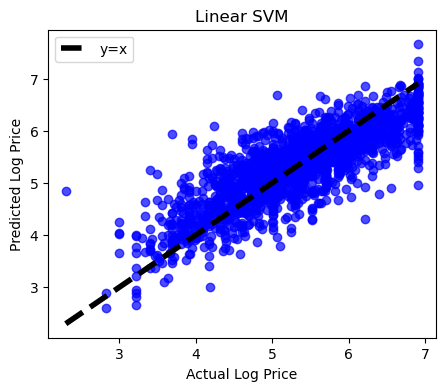

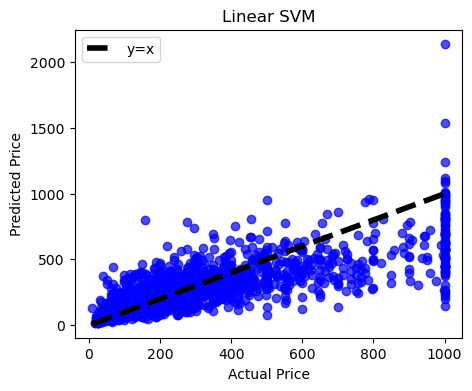

bins
$0-$100       26.985634
$100-$200     46.058423
$200-$500     71.620276
$500-max     244.557436
Name: mse_error, dtype: float64


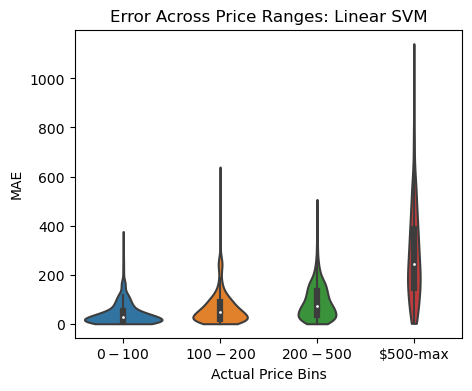

In [46]:
from sklearn.svm import SVR

svr = SVR(kernel='linear')  

# Run model with helper function
y_train_pred, y_val_pred = execute_model(svr, model_meta_data, X_train, X_val, y_train, y_val, 'lin-reg')

plot_pred_actual(y_val, y_val_pred,'Linear SVM')
plot_pred_actual_inv(y_val, y_val_pred,'Linear SVM')
analyze_predictions(y_val,y_val_pred, 'Linear SVM')

### Non-linear Models

### Non-Linear SVM

{'fit_time': array([4.56524611, 3.10976601, 3.0847168 , 3.39464998, 2.98334908]), 'score_time': array([2.39804387, 1.58210707, 1.48919225, 1.51970601, 1.57136798]), 'test_r2': array([0.71274838, 0.68926125, 0.66383182, 0.68844237, 0.69536577]), 'train_r2': array([0.80008338, 0.80191616, 0.80504604, 0.80182095, 0.80214653]), 'test_neg_mean_squared_error': array([-0.21959245, -0.21574224, -0.25572762, -0.23679412, -0.24368757]), 'train_neg_mean_squared_error': array([-0.15071589, -0.15281556, -0.14716784, -0.14960051, -0.14741631])}
model SVR()
id lin-reg
r2_train 0.8000339302948698
r2_test 0.7045653057769811
r2_train_inv 0.7491655218184399
r2_test_inv 0.6390824528833838
train_cross_val_r2 0.8022026121743036
test_cross_val_r2 0.6899299181524284
mse_train 0.15118446982357964
mse_test 0.22223916306234726
mse_train_inv 16767.92581298085
mse_test_inv 22429.66686174617
train_cross_val_mse 0.14954322040649917
test_cross_val_mse 0.23430880128271445


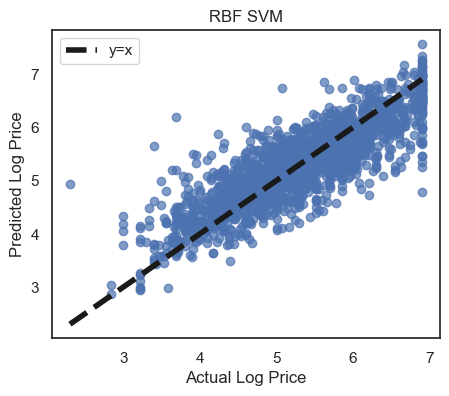

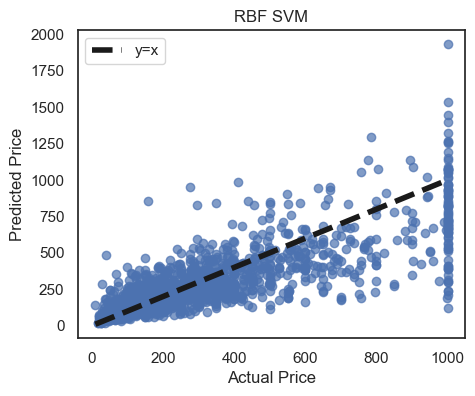

bins
$0-$100       26.650756
$100-$200     35.665213
$200-$500     66.625699
$500-max     225.349430
Name: mse_error, dtype: float64


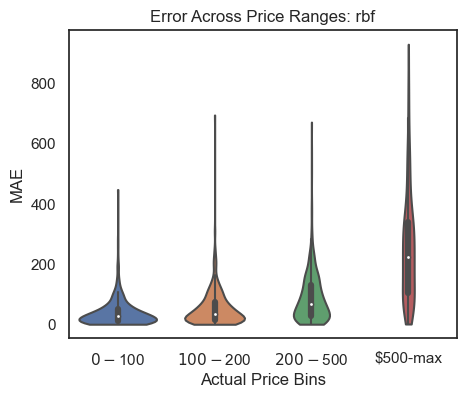

In [31]:
svr = SVR(kernel='rbf')  

# Run model with helper function
y_train_pred, y_val_pred = execute_model(svr, model_meta_data, X_train, X_val, y_train, y_val, 'lin-reg')

plot_pred_actual(y_val, y_val_pred,'RBF SVM')
plot_pred_actual_inv(y_val, y_val_pred,'RBF SVM')
analyze_predictions(y_val,y_val_pred, 'rbf')

#### Random Forest Regression

{'fit_time': array([18.33580589, 15.10964513, 14.90488195, 15.60338521, 14.00206208]), 'score_time': array([0.22673798, 0.08496499, 0.07205606, 0.25587201, 0.09389305]), 'test_r2': array([0.71575743, 0.68433875, 0.67463785, 0.66587975, 0.69929417]), 'train_r2': array([0.95633151, 0.95770015, 0.95683728, 0.95714596, 0.95650454]), 'test_neg_mean_squared_error': array([-0.21729215, -0.21915988, -0.24750733, -0.25394246, -0.24054511]), 'train_neg_mean_squared_error': array([-0.0329214 , -0.03263302, -0.0325829 , -0.03234947, -0.03240752])}
model RandomForestRegressor(n_estimators=180)
id random-forest
r2_train 0.9581990118179093
r2_test 0.6930245283576517
r2_train_inv 0.9267349912484516
r2_test_inv 0.6477450759454517
train_cross_val_r2 0.9569038879624557
test_cross_val_r2 0.687981589173955
mse_train 0.03160366279004264
mse_test 0.2309206509339933
mse_train_inv 4897.660960883285
mse_test_inv 21891.317449301878
train_cross_val_mse 0.032578861183239924
test_cross_val_mse 0.2356893853581777


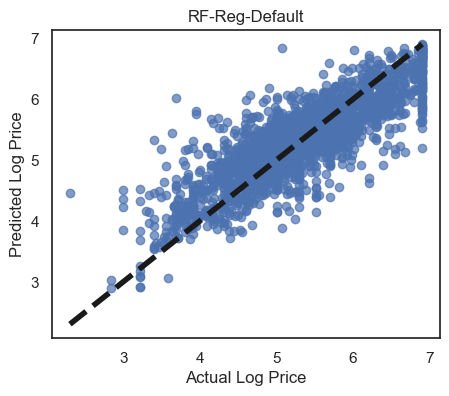

In [45]:
rf_reg  = RandomForestRegressor(n_estimators=180)

y_train_pred, y_val_pred = execute_model(rf_reg, model_meta_data, X_train, X_val, y_train, y_val, 'random-forest')

plot_pred_actual(y_val, y_val_pred, 'RF-Reg-Default')

{'fit_time': array([5.19885683, 4.88239384, 5.1404388 , 4.90006614, 5.11930418]), 'score_time': array([0.04174805, 0.03368807, 0.03066587, 0.03112888, 0.0317421 ]), 'test_r2': array([0.66094489, 0.62643766, 0.61594635, 0.61653066, 0.64090732]), 'train_r2': array([0.70354325, 0.71409435, 0.71371956, 0.71341989, 0.70962725]), 'test_neg_mean_squared_error': array([-0.25919416, -0.25935992, -0.29215474, -0.29144939, -0.28725079]), 'train_neg_mean_squared_error': array([-0.22349689, -0.22056737, -0.21610884, -0.2163323 , -0.2163504 ])}
model RandomForestRegressor(max_depth=7, n_estimators=180)
id random-forest
r2_train 0.700049166547273
r2_test 0.631427920024914
r2_train_inv 0.5935388243290844
r2_test_inv 0.5652544084362774
train_cross_val_r2 0.7108808612227723
test_cross_val_r2 0.6321533780043838
mse_train 0.22677801186752014
mse_test 0.2772563689489299
mse_train_inv 27171.347770515255
mse_test_inv 27017.80189489194
train_cross_val_mse 0.21857116016857714
test_cross_val_mse 0.2778818003347

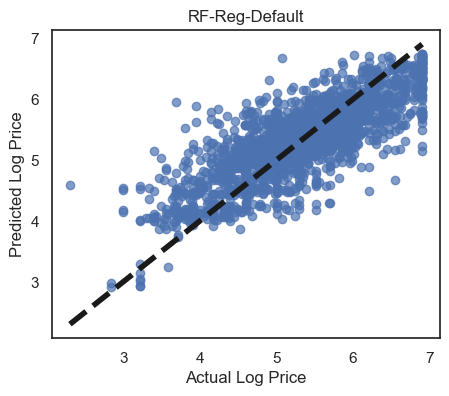

In [359]:
rf_reg  = RandomForestRegressor(max_depth = 7, n_estimators=180)

y_train_pred, y_val_pred = execute_model(rf_reg, model_meta_data, X_train, X_val, y_train, y_val, 'random-forest')

plot_pred_actual(y_val, y_val_pred, 'RF-Reg-Optim')

{'fit_time': array([5.49234509, 5.25589705, 5.31117606, 5.02941704, 5.20315409]), 'score_time': array([0.03187895, 0.03073978, 0.03539896, 0.0310111 , 0.03061485]), 'test_r2': array([0.65118676, 0.61993615, 0.60928286, 0.60578568, 0.63148642]), 'train_r2': array([0.70157624, 0.71016572, 0.71160908, 0.71413766, 0.70795376]), 'test_neg_mean_squared_error': array([-0.314021  , -0.29790678, -0.33952948, -0.3488069 , -0.33602798]), 'train_neg_mean_squared_error': array([-0.25738264, -0.2584402 , -0.25101482, -0.24764067, -0.25106724])}
model RandomForestRegressor(max_depth=7, n_estimators=180)
id random-forest
r2_train 0.6984662472378288
r2_test 0.625492266519767
train_cross_val_r2 0.709088492056097
test_cross_val_r2 0.6235355718203763
mse_train 0.2623695446583427
mse_test 0.32137153969262816
train_cross_val_mse 0.25310911261275615
test_cross_val_mse 0.32725842965928187


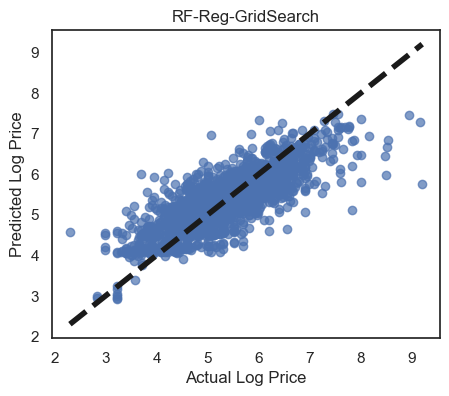

In [37]:
# Create base random forest regressor
rf_reg  = RandomForestRegressor(max_depth = 7, n_estimators=180)

y_train_pred, y_val_pred = execute_model(rf_reg, model_meta_data, X_train, X_val, y_train, y_val, 'random-forest')

plot_pred_actual(y_val, y_val_pred, 'RF-Reg-GridSearch')

Use grid search to reduce overfitting

In [68]:
# RF model
estimator = RandomForestRegressor()

# Hyperparameter tuning
parameters = {
    'max_depth': list(range(6, 12, 1)) + [None],
    'n_estimators': range(100, 220, 40),
}

# Apply grid search
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = 10,
    cv = 5,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=10,
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, None],
                         'n_estimators': range(100, 220, 40)},
             return_train_score=True, scoring='r2', verbose=1)

In [69]:
results = pd.DataFrame(grid_search.cv_results_)
results['dif'] = results['mean_train_score'] - results['mean_test_score']
results.sort_values('dif')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       10.655199      0.028116         0.061813        0.009027   
1        9.894683      0.020275         0.074494        0.007674   
0        7.347175      0.021432         0.073871        0.012684   
5       11.095965      0.015170         0.070132        0.003660   
4        8.748331      0.017411         0.056215        0.004337   
3        6.760749      0.011348         0.038417        0.003915   
6        7.381148      0.021192         0.052277        0.006092   
7       16.791541      0.135278         0.180919        0.060517   
8       24.411271      0.235861         0.313830        0.078245   
9       15.053635      0.055311         0.105490        0.010769   
11      26.093223      0.110189         0.242238        0.035516   
10      20.824756      0.120832         0.134785        0.015071   
14      16.028311      0.025565         0.084458        0.006023   
12      15.522193      0.025294         0.086076        0.020586   
13      15.279648      0.077023         0.076179        0.014892   
15       9.211562      0.030205         0.054816        0.004145   
17      20.991430      0.025312         0.311807        0.112502   
16      12.907379      0.041907         0.084239        0.006683   
20      21.510196      0.161447         0.092897        0.002664   
19      23.197630      0.110472         0.193738        0.086510   
18      20.542894      0.037852         0.168869        0.012107   

   param_max_depth param_n_estimators  \
2                6                180   
1                6                140   
0                6                100   
5                7                180   
4                7                140   
3                7                100   
6                8                100   
7                8                140   
8                8                180   
9                9                100   
11               9                180   
10               9                140   
14              10                180   
12              10                100   
13              10                140   
15              11                100   
17              11                180   
16              11                140   
20            None                180   
19            None                140   
18            None                100   

                                      params  split0_test_score  \
2      {'max_depth': 6, 'n_estimators': 180}           0.640048   
1      {'max_depth': 6, 'n_estimators': 140}           0.638201   
0      {'max_depth': 6, 'n_estimators': 100}           0.638699   
5      {'max_depth': 7, 'n_estimators': 180}           0.660762   
4      {'max_depth': 7, 'n_estimators': 140}           0.660560   
3      {'max_depth': 7, 'n_estimators': 100}           0.661329   
6      {'max_depth': 8, 'n_estimators': 100}           0.679693   
7      {'max_depth': 8, 'n_estimators': 140}           0.677394   
8      {'max_depth': 8, 'n_estimators': 180}           0.679534   
9      {'max_depth': 9, 'n_estimators': 100}           0.692722   
11     {'max_depth': 9, 'n_estimators': 180}           0.690832   
10     {'max_depth': 9, 'n_estimators': 140}           0.691725   
14    {'max_depth': 10, 'n_estimators': 180}           0.699142   
12    {'max_depth': 10, 'n_estimators': 100}           0.702280   
13    {'max_depth': 10, 'n_estimators': 140}           0.697172   
15    {'max_depth': 11, 'n_estimators': 100}           0.704327   
17    {'max_depth': 11, 'n_estimators': 180}           0.705918   
16    {'max_depth': 11, 'n_estimators': 140}           0.703200   
20  {'max_depth': None, 'n_estimators': 180}           0.717789   
19  {'max_depth': None, 'n_estimators': 140}           0.715216   
18  {'max_depth': None, 'n_estimators': 100}           0.716260   

    split1_test_score  split2_test_score  ...  std_test_score  \
2            0.618900           0.600485  ...        0.014821   

We find that the optimal hyperparameters for the random forest are a `max_depth` of 6-7 and `n_estimators` of 180. 

#### Xgboost

{'fit_time': array([1.62262177, 2.92618799, 2.41817474, 1.9179492 , 1.52035999]), 'score_time': array([0.0112052 , 0.02764416, 0.02005315, 0.01254487, 0.0138061 ]), 'test_r2': array([0.71479758, 0.66823746, 0.66182386, 0.68191764, 0.68479998]), 'train_r2': array([0.93895337, 0.94142813, 0.9472683 , 0.94675643, 0.94411511]), 'test_neg_mean_squared_error': array([-0.21802592, -0.23033881, -0.2572551 , -0.24175312, -0.25213952]), 'train_neg_mean_squared_error': array([-0.04602267, -0.04518639, -0.03980637, -0.04019227, -0.04163861])}
model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_ca

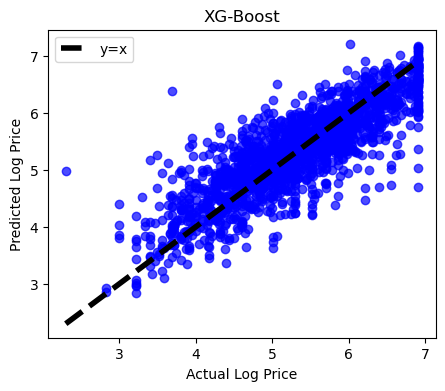

In [47]:
# xgboost regressor with default parameters only
xgb_reg = xgb.XGBRegressor()

y_train_pred, y_val_pred = execute_model(xgb_reg, model_meta_data, X_train, X_val, y_train, y_val, 'xg-boost')

plot_pred_actual(y_val, y_val_pred, 'XG-Boost')

Note the substantial amount of overfitting, the validation r^2 is approximately 22% higher than the training r^2. Hence, the hyperparameters should be optimized to reduce overfitting. 

In [48]:
from sklearn.model_selection import GridSearchCV


# xgboost regressor
estimator = xgb.XGBRegressor(seed=42, nthread=4)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'alpha': [0, 0.1, 1, 10, 30, 100]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = 10,
    cv = 5,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, nthread=4,
                                    num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'alpha': [0, 0.1, 1, 10, 30, 100],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='r2', verbose=1)

In [49]:
results = pd.DataFrame(grid_search.cv_results_)
# results['dif'] = results['mean_train_score'] - results['mean_test_score']
results.sort_values('mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
160       1.558980      0.030855         0.017584        0.001571         100   
161       2.403537      0.069292         0.017871        0.002349         100   
162       3.254436      0.022729         0.020035        0.002036         100   
163       3.857875      0.028322         0.018554        0.002921         100   
164       2.042878      0.050489         0.018090        0.001951         100   
..             ...           ...              ...             ...         ...   
105       7.724049      0.142441         0.020946        0.001913          10   
71       11.556892      0.132300         0.027913        0.004774           1   
106       9.167650      0.578351         0.023420        0.001233          10   
107       9.499597      0.609604         0.025004        0.005006          10   
103       9.611222      0.367172         0.021086        0.003719          10   

    param_max_depth param_n_estimators  \
160               2                 60   
161               2                100   
162               2                140   
163               2                180   
164               3                 60   
..              ...                ...   
105               4                100   
71                3                180   
106               4                140   
107               4                180   
103               3                180   

                                                params  split0_test_score  \
160  {'alpha': 100, 'max_depth': 2, 'n_estimators':...           0.642810   
161  {'alpha': 100, 'max_depth': 2, 'n_estimators':...           0.642810   
162  {'alpha': 100, 'max_depth': 2, 'n_estimators':...           0.642810   
163  {'alpha': 100, 'max_depth': 2, 'n_estimators':...           0.642810   
164  {'alpha': 100, 'max_depth': 3, 'n_estimators':...           0.652272   
..                                                 ...                ...   
105  {'alpha': 10, 'max_depth': 4, 'n_estimators': ...           0.726822   
71   {'alpha': 1, 'max_depth': 3, 'n_estimators': 180}           0.730258   
106  {'alpha': 10, 'max_depth': 4, 'n_estimators': ...           0.726660   
107  {'alpha': 10, 'max_depth': 4, 'n_estimators': ...           0.726660   
103  {'alpha': 10, 'max_depth': 3, 'n_estimators': ...           0.734480   

     split1_test_score  split2_test_score  split3_test_score  \
160           0.611777           0.585054           0.611421   
161           0.611777           0.585054           0.611421   
162           0.611777           0.585054           0.611421   
163           0.611777           0.585054           0.611421   
164           0.616856           0.606722           0.629814   
..                 ...                ...                ...   
105           0.703217           0.689200           0.708343   
71            0.700672           0.688055           0.710777   
106           0.703235           0.689018           0.708343   
107           0.703235           0.689018           0.708343   
103           0.702614           0.681716           0.715616   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
160           0.619807         0.614174        0.018510              189  
161           0.619807         0.614174        0.018510              189  
162           0.619807         0.614174        0.018510              189  
163           0.619807         0.614174        0.018510              189  
164           0.631096         0.627352        0.015342              185  
..                 ...              ...             ...              ...  
105           0.693869         0.704290        0.013127                5  
71            0.692288         0.704410        0.015080                4  
106           0.695273         0.704506        0.012902                2  
107           0.695273         0.704506        0.012902                2  
103     

### Optimal parameters from gridsearch to avoid overfitting

{'fit_time': array([1.98071599, 1.74232197, 1.44849014, 2.054986  , 1.47459722]), 'score_time': array([0.01804018, 0.01518893, 0.03594184, 0.01538491, 0.01531863]), 'test_r2': array([0.70184782, 0.68448692, 0.64924293, 0.68257496, 0.67903854]), 'train_r2': array([0.74231748, 0.74772386, 0.74772712, 0.74578002, 0.74525506]), 'test_neg_mean_squared_error': array([-0.2279255 , -0.219057  , -0.26682559, -0.24125354, -0.2567483 ]), 'train_neg_mean_squared_error': array([-0.19426524, -0.19462324, -0.19043704, -0.19190443, -0.18980489])}
model XGBRegressor(alpha=30, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=

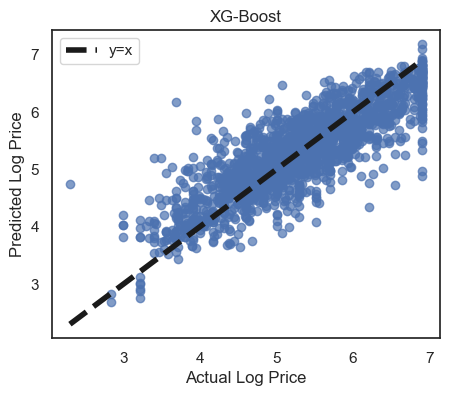

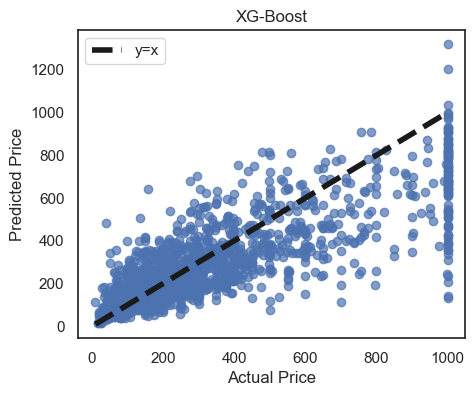

bins
$0-$100       24.843258
$100-$200     40.039865
$200-$500     75.903252
$500-max     218.165588
Name: mse_error, dtype: float64


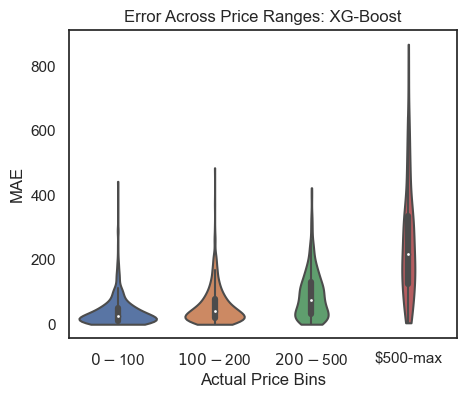

In [41]:
# xgboost regressor with modified parameters
xgb_reg = xgb.XGBRegressor(n_estimators=180, max_depth=6, alpha=30)

y_train_pred, y_val_pred = execute_model(xgb_reg, model_meta_data, X_train, X_val, y_train, y_val, 'xg-boost')

plot_pred_actual(y_val, y_val_pred, 'XG-Boost')
plot_pred_actual_inv(y_val, y_val_pred,'XG-Boost')
analyze_predictions(y_val,y_val_pred, 'XG-Boost')

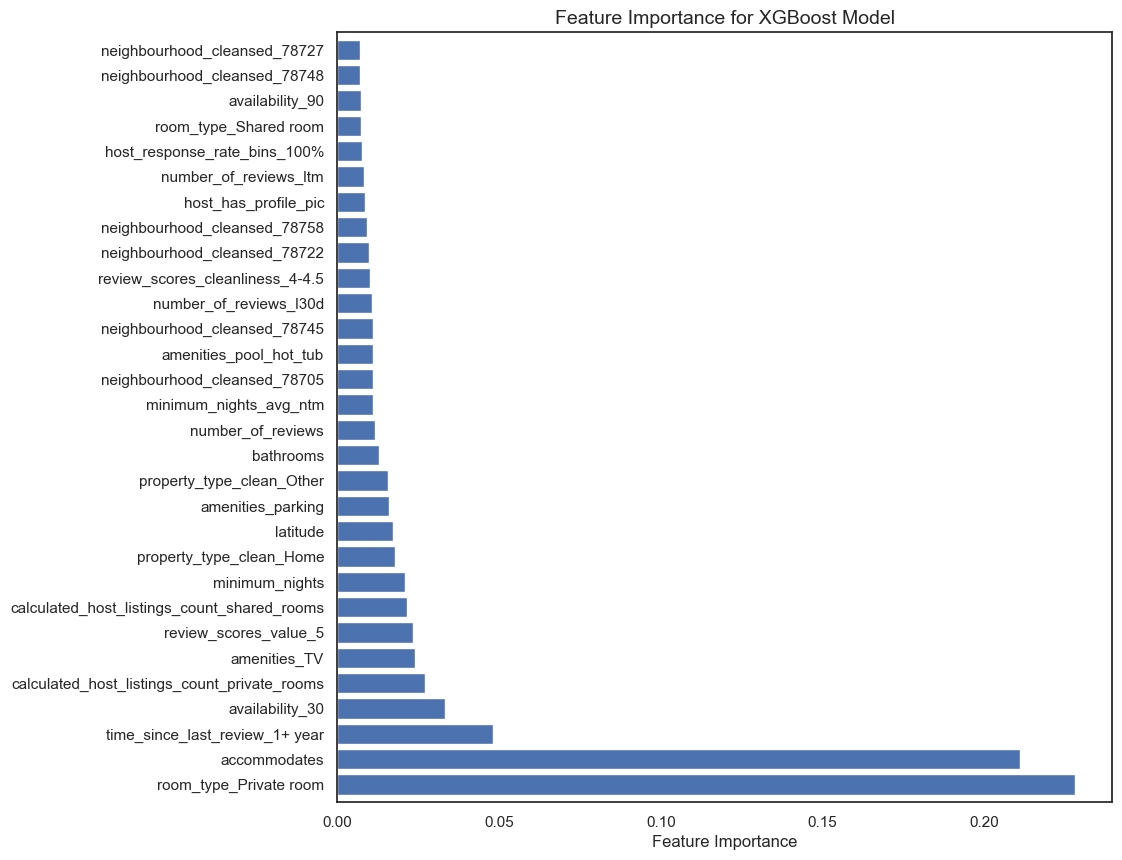

In [42]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)

final = ft_weights_xgb_reg.head(30)

# Plotting feature importances
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(final.index, final.weight, align='center') 
plt.title("Feature Importance for XGBoost Model", fontsize=14)
plt.xlabel("Feature Importance")
plt.margins(y=0.01)
plt.show()

In [44]:
feature_subset = final.index.values.tolist()
feature_subset

['room_type_Private room',
 'accommodates',
 'time_since_last_review_1+ year',
 'availability_30',
 'calculated_host_listings_count_private_rooms',
 'amenities_TV',
 'review_scores_value_5',
 'calculated_host_listings_count_shared_rooms',
 'minimum_nights',
 'property_type_clean_Home',
 'latitude',
 'amenities_parking',
 'property_type_clean_Other',
 'bathrooms',
 'number_of_reviews',
 'minimum_nights_avg_ntm',
 'neighbourhood_cleansed_78705',
 'amenities_pool_hot_tub',
 'neighbourhood_cleansed_78745',
 'number_of_reviews_l30d',
 'review_scores_cleanliness_4-4.5',
 'neighbourhood_cleansed_78722',
 'neighbourhood_cleansed_78758',
 'host_has_profile_pic',
 'number_of_reviews_ltm',
 'host_response_rate_bins_100%',
 'room_type_Shared room',
 'availability_90',
 'neighbourhood_cleansed_78748',
 'neighbourhood_cleansed_78727']

{'fit_time': array([0.80894089, 0.53197122, 0.75772595, 0.53972292, 0.68225789]), 'score_time': array([0.00496602, 0.00529099, 0.0068481 , 0.00825787, 0.00678182]), 'test_r2': array([0.67759624, 0.65920349, 0.62917692, 0.6515259 , 0.66708948]), 'train_r2': array([0.69896178, 0.70510576, 0.70673014, 0.70361935, 0.70079854]), 'test_neg_mean_squared_error': array([-0.24646486, -0.23661099, -0.28209007, -0.26485186, -0.26630677]), 'train_neg_mean_squared_error': array([-0.22695083, -0.22750179, -0.22138506, -0.22373049, -0.22292848])}
model XGBRegressor(alpha=30, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=

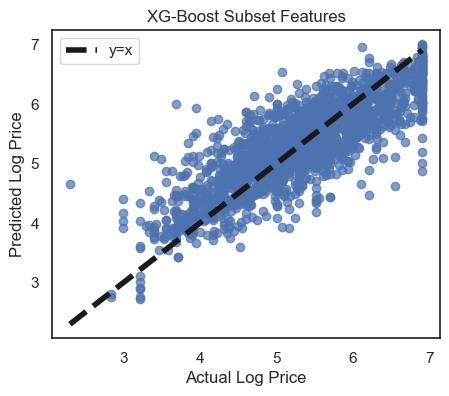

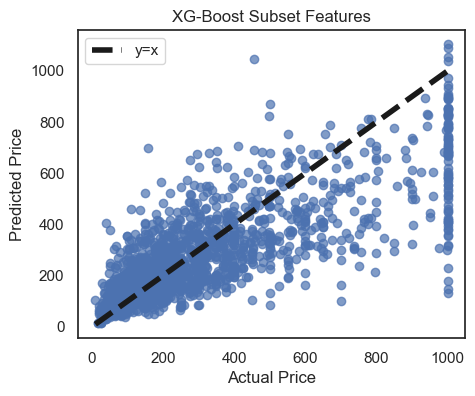

bins
$0-$100       28.196594
$100-$200     40.591374
$200-$500     77.572855
$500-max     237.077728
Name: mse_error, dtype: float64


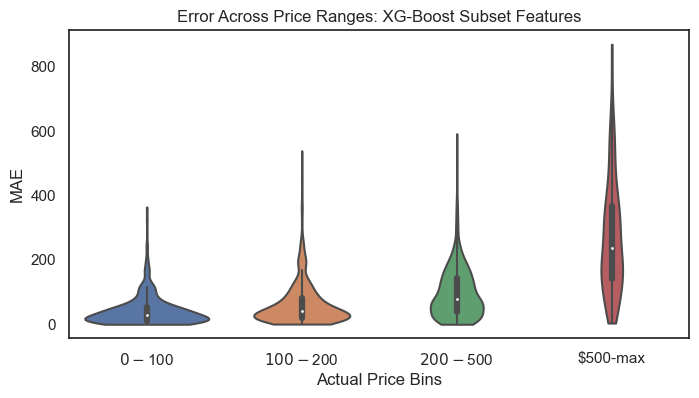

In [194]:
# Get top 30 feature names
feature_subset = final.index.values.tolist()

xgb_reg = xgb.XGBRegressor(n_estimators=180, max_depth=6, alpha=30)

y_train_pred, y_test_pred = execute_model(xgb_reg, model_meta_data, X_train[feature_subset], X_val[feature_subset], y_train, y_val, 'xg-boost')

plot_pred_actual(y_val, y_test_pred, 'XG-Boost Subset Features')
plot_pred_actual_inv(y_val, y_test_pred,'XG-Boost Subset Features')
analyze_predictions(y_val,y_test_pred, 'XG-Boost Subset Features')

In [ ]:
# Apple RFECV to linear regression model

min_features_to_select = 5

xgb_reg = xgb.XGBRegressor(n_estimators=180, max_depth=6, alpha=30)

cv = KFold(5)

rfecv = RFECV(
    estimator=xgb_reg,
    step=1,
    cv=cv,
    scoring="r2",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBRegressor(alpha=30, base_score=None, booster=None,
                             callbacks=None, colsample_bylevel=None,
                             colsample_bynode=None, colsample_bytree=None,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, gpu_id=None,
                             grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=None,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=6, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=180,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, ...),
      min_features_to_select=5, n_jobs=2, scoring='r2')

In [338]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 81


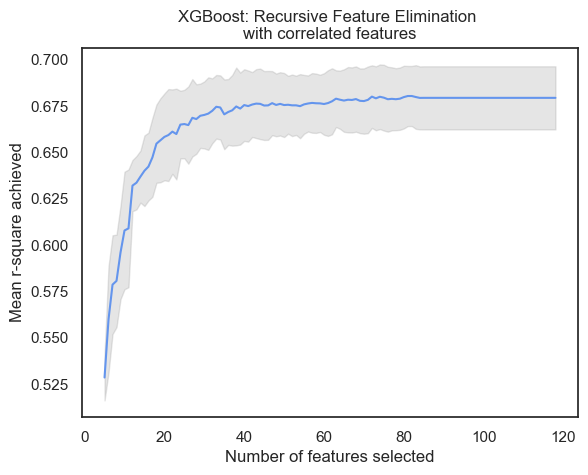

In [348]:
scores = rfecv.cv_results_["mean_test_score"]
yerr = rfecv.cv_results_["std_test_score"]
n_scores = len(rfecv.cv_results_["mean_test_score"])
feature_range = range(min_features_to_select, n_scores + min_features_to_select)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean r-square achieved")

plt.plot(feature_range, scores, '-', color='cornflowerblue')
plt.plot()
plt.fill_between(feature_range, scores - yerr, scores + yerr,
                 color='gray', alpha=0.2)
plt.title("XGBoost: Recursive Feature Elimination \nwith correlated features")
plt.show()

In [46]:

xgb_reg = xgb.XGBRegressor(n_estimators=180, max_depth=6, alpha=30)

rfe = RFE(estimator=xgb_reg, n_features_to_select=30, step=1)
rfe.fit(X_train, y_train)


RFE(estimator=XGBRegressor(alpha=30, base_score=None, booster=None,
                           callbacks=None, colsample_bylevel=None,
                           colsample_bynode=None, colsample_bytree=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           gpu_id=None, grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=6, max_leaves=None, min_child_weight=None,
                           missing=nan, monotone_constraints=None,
                           n_estimators=180, n_jobs=None,
                           num_parallel_tree=None, predictor=None, ...),
    n_features_to_select=30)

{'fit_time': array([0.831532  , 0.44844103, 0.41981697, 0.538167  , 0.41718507]), 'score_time': array([0.00776029, 0.00595903, 0.01734233, 0.006253  , 0.00464201]), 'test_r2': array([0.70010176, 0.66457864, 0.64495504, 0.67704906, 0.67204879]), 'train_r2': array([0.72400574, 0.72739972, 0.72755842, 0.72988623, 0.72758584]), 'test_neg_mean_squared_error': array([-0.22926029, -0.23287908, -0.27008744, -0.24545341, -0.26233965]), 'train_neg_mean_squared_error': array([-0.20807035, -0.21030269, -0.2056621 , -0.20390227, -0.20296985])}
model XGBRegressor(alpha=30, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=

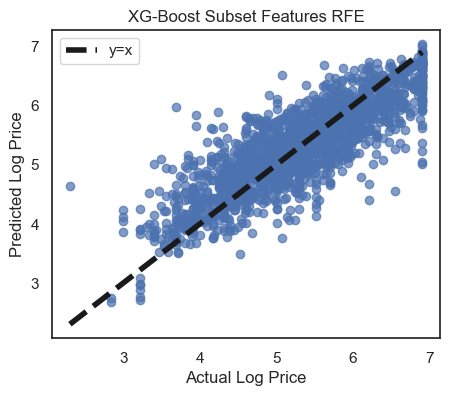

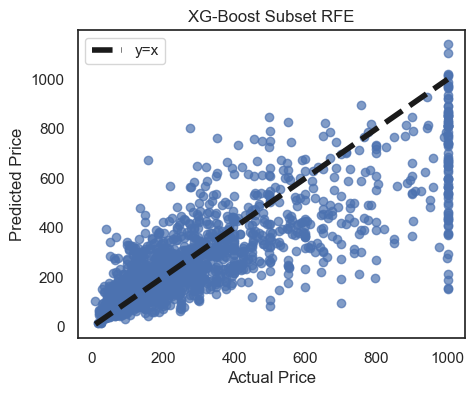

bins
$0-$100       26.383869
$100-$200     41.372441
$200-$500     73.474147
$500-max     222.375305
Name: mse_error, dtype: float64


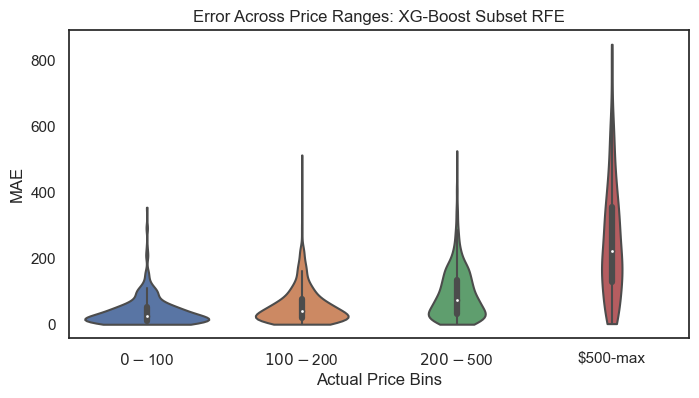

In [196]:
feature_subset = X_train.columns[rfe.support_]

xgb_reg = xgb.XGBRegressor(n_estimators=180, max_depth=6, alpha=30)

y_train_pred, y_test_pred = execute_model(xgb_reg, model_meta_data, X_train[feature_subset], X_val[feature_subset], y_train, y_val, 'xg-boost')

plot_pred_actual(y_val, y_test_pred, 'XG-Boost Subset Features RFE')
plot_pred_actual_inv(y_val, y_test_pred,'XG-Boost Subset RFE')
analyze_predictions(y_val,y_test_pred, 'XG-Boost Subset RFE')

{'fit_time': array([0.8165431 , 1.04895806, 0.9382    , 1.17078805, 0.69180393]), 'score_time': array([0.00847316, 0.00744319, 0.00770473, 0.01752496, 0.00677705]), 'test_r2': array([0.70010176, 0.66457864, 0.64495504, 0.67704906, 0.67204879]), 'train_r2': array([0.72400574, 0.72739972, 0.72755842, 0.72988623, 0.72758584]), 'test_neg_mean_squared_error': array([-0.22926029, -0.23287908, -0.27008744, -0.24545341, -0.26233965]), 'train_neg_mean_squared_error': array([-0.20807035, -0.21030269, -0.2056621 , -0.20390227, -0.20296985])}
model XGBRegressor(alpha=30, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=

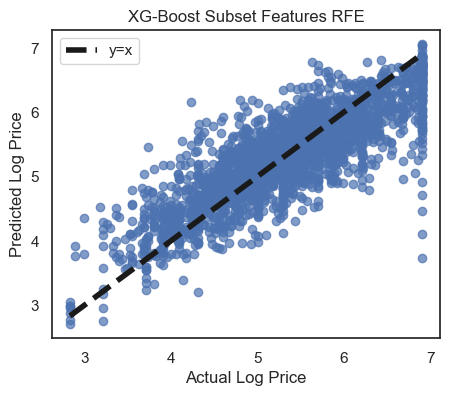

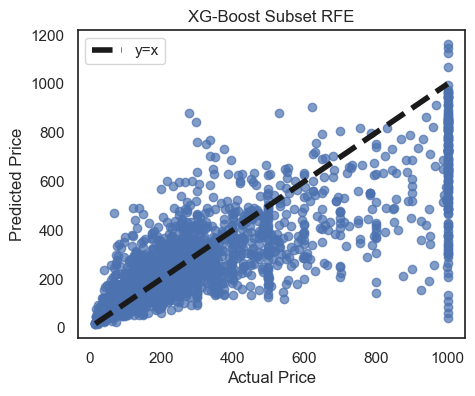

bins
$0-$100       23.971152
$100-$200     35.991242
$200-$500     73.799647
$500-max     250.906525
Name: mse_error, dtype: float64


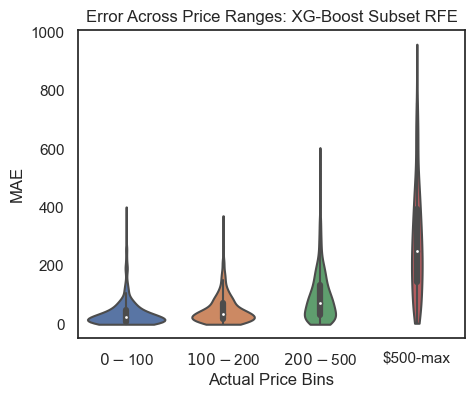

In [47]:
feature_subset = X_train.columns[rfe.support_]

xgb_reg = xgb.XGBRegressor(n_estimators=180, max_depth=6, alpha=30)

y_train_pred, y_test_pred = execute_model(xgb_reg, model_meta_data, X_train[feature_subset], X_test[feature_subset], y_train, y_test, 'xg-boost')

plot_pred_actual(y_test, y_test_pred, 'XG-Boost Subset Features RFE')
plot_pred_actual_inv(y_test, y_test_pred,'XG-Boost Subset RFE')
analyze_predictions(y_test,y_test_pred, 'XG-Boost Subset RFE')

### Geospatial

In [26]:
zips = df['neighbourhood_cleansed'].unique().tolist()

In [27]:
cols = X_test.columns[X_test.columns.str.startswith("neighbourhood")]
df_n = X_test[cols].copy()
df_n.columns = df_n.columns.str.removeprefix("neighbourhood_cleansed_")

for code in zips:
    if code not in df_n.columns.values.tolist():
        print(code)

78701


In [28]:
df_n['78701'] = (df_n.sum(axis=1) == 0)
zips = pd.from_dummies(df_n).rename(columns={'': 'Zip'})


In [29]:
y_test

6614     6.424869
9551     3.688879
10954    5.707110
9629     5.991465
5624     6.052089
           ...   
10130    5.262690
2117     3.401197
9178     5.337538
2240     4.543295
426      5.991465
Name: price, Length: 2249, dtype: float64

In [30]:
# Get error segmented by neighborhood
zips['actual'] = np.exp(y_test.to_numpy())
zips['pred'] = np.exp(y_test_pred)
zips['mse_error'] = (zips['actual']-zips['pred'] )**2

In [30]:
zips

Zip  actual        pred     mse_error
0     78701   617.0  557.465637   3544.340353
1     78753    40.0   78.934433   1515.890072
2     78701   301.0  305.059296     16.477881
3     78704   400.0  270.033783  16891.217572
4     78704   425.0  373.174652   2685.866685
...     ...     ...         ...           ...
2244  78741   193.0  200.057816     49.812760
2245  78703    30.0   65.907890   1289.376587
2246  78737   208.0  157.565933   2543.595091
2247  78741    94.0   95.432549      2.052195
2248  78759   400.0  136.805801  69271.186181

[2249 rows x 4 columns]

In [31]:
data = zips.groupby("Zip")['mse_error'].mean().reset_index()


In [37]:
data['mse_error'] = np.sqrt(data['mse_error'] )

In [32]:
import geopandas as gpd

geojson_data_path = './airbnb_data/austin/neighbourhoods.geojson'

map_df = gpd.read_file('./airbnb_data/austin/neighbourhoods.geojson')

map_df.drop('neighbourhood_group', axis = 1, inplace=True)

map_df.head()

neighbourhood                                           geometry
0         78739  MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...
1         78754  MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ...
2         78732  MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ...
3         78737  MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ...
4         78756  MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ...

In [38]:
# Merge geojson geometry data with the neighbourhood data 
geo_data_merged = pd.merge(map_df, data, how='inner',left_on='neighbourhood', right_on='Zip')

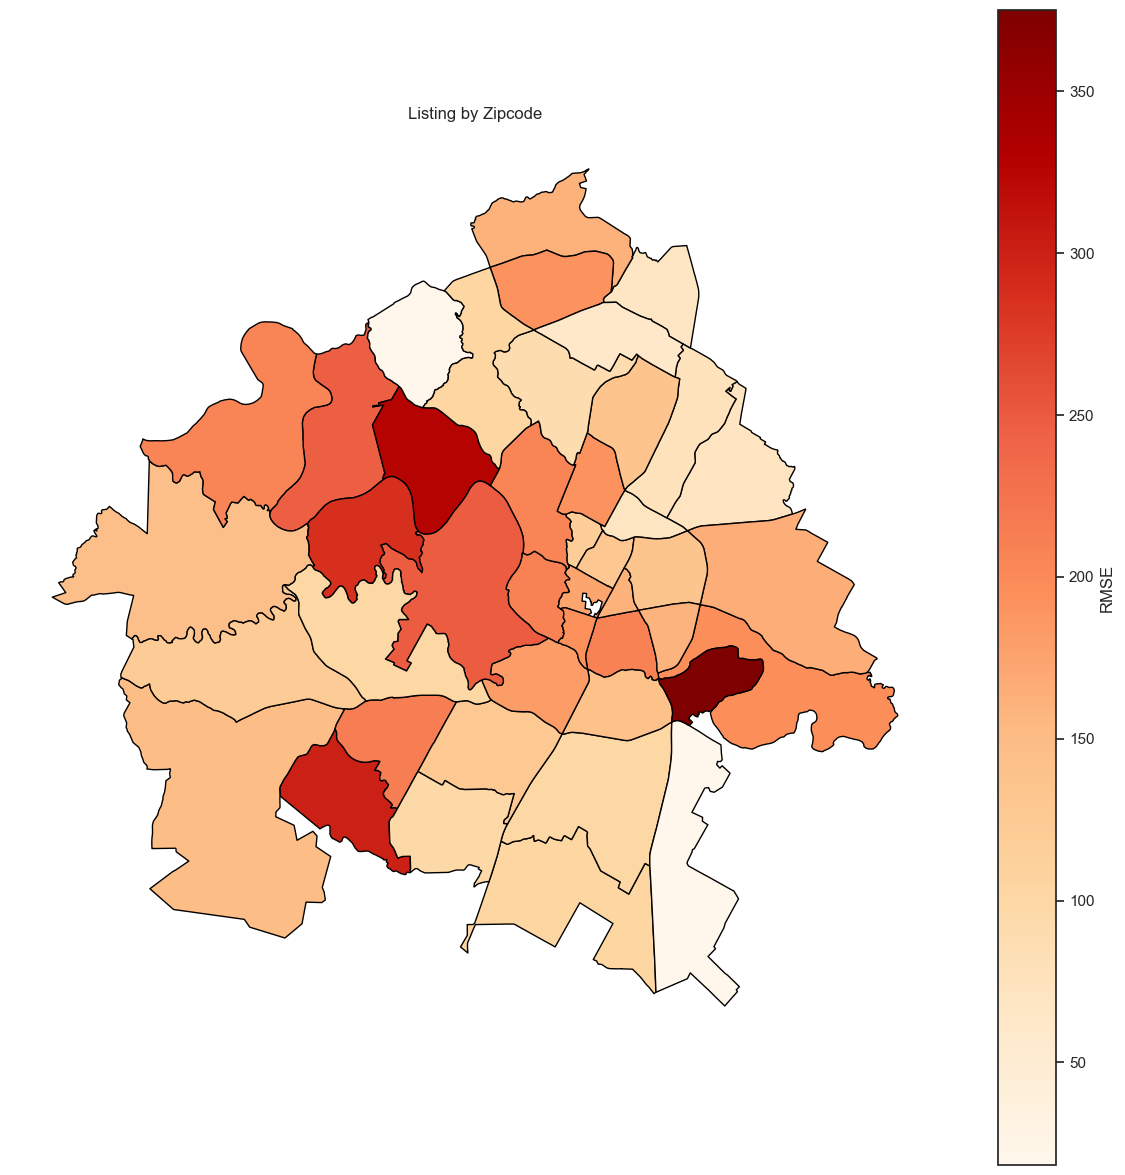

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
geo_data_merged.plot(column='mse_error',legend=True, cmap='OrRd', legend_kwds={'label': "RMSE"}, edgecolor='black',ax=ax)
ax.set_axis_off()
ax.set(title="Listing by Zipcode")
plt.show()